## Lab 5 Distributed Learning with Graph Neural Networks
*Alejandro Ribeiro, Zhan Gao and Alejandro Parada Mayorga*


Graph neural networks (GNNs) explore the irregular structure of graph signals, and exhibit superior performance in various applications of recommendation systems, wireless networks and control. A key property GNNs inherit from graph filters is the distributed implementation. This property makes them suitable candidates for distributed learning over large-scale networks, where global information is not available at individual agents. Each agent must decide its own actions from local observations and communication with immediate neighbors. In this lab assignment, we focus on the distributed learning with graph neural networks.

## 0. Environment setup

In [5]:
import numpy as np
import os
import torch as torch
torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
import os
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import copy
import heapq
import datetime
from copy import deepcopy
from abc import ABC
from typing import Optional
rng = np.random
plt.rc('text', usetex=False)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["font.size"] = "12"

# 1 Distributed Control Systems

We consider a team of $N$ agents tasked with controlling a dynamical process that is evolving in the space where the team is deployed. The system is distributed because the agents are located in different positions. We characterize this dynamical process by the collection of state values $\mathbf{x}_{i}(t)\in\mathbb{R}^p$ as well as the collection of
control actions $\mathbf{u}_{i}(t)\in\mathbb{R}^q$ that agents take. In this notation, $i$ represents an agent index and $t$ represents continuous time. We further group local states and local actions into matrices $\mathbf{X}(t) = [\mathbf{x}_{1}(t), \ldots, \mathbf{x}_{N}(t)]^{T}\in\mathbb{R}^{N\times p}$ and $\mathbf{U}(t) = [\mathbf{u}_{1}(t), \ldots, \mathbf{u}_{N}(t)]^{T}\in\mathbb{R}^{N\times q}$ that represent the global state of the system and the global control action at time $t$. Observe that
row $n$ of $\mathbf{X}(t)$ is the state associated with agent $n$ and that
row $n$ of $\mathbf{U}(t)$ is the control action taken by agent $n$.

With these definitions we write the evolution of the dynamical process through a differential equation of the form,
$$
\dot{\mathbf{X}}(t) = f\Big(\mathbf{X}(t), \mathbf{U}(t)\Big).
$$
In order to design a controller for this dynamical system we operate in discrete time by introducing a sampling time $T_s$ and a discrete time index $n$. We define $\mathbf{X}_{n} = \mathbf{X}(nT_s)$ as the discrete time state and $\mathbf{U}_{n}$ as the control action held from time $nT_s$ until time $(n+1)T_s$. Solving the differential equation between times $nT_s$ and $(n+1)T_s$, we end up with the discrete dynamical system
$$
\mathbf{X}_{n+1} =
\mathbf{X}_n +
\int_{nT_s}^{(n+1)T_s}
f \Big(\mathbf{X}(t),\mathbf{U}_{n}\Big)\, dt,
\qquad
\text{with } \mathbf{X}(nT_s) = \mathbf{X}_{n}.
$$
At each point in (discrete) time, we consider a cost function $c(\mathbf{X}_n, \mathbf{U}_n)$. The objective of the control system is to choose actions $\mathbf{U}_n$ that reduce the accumulated cost $\sum_{n=0}^\infty c(\mathbf{X}_n, \mathbf{U}_n)$.
When the collection of state observations $\mathbf{X}_{n} = [\mathbf{x}_{1n}^{T};\ldots;\mathbf{x}_{Nn}^{T}]$ is available at a central location it is possible for us to consider centralized policies $\Pi$ that choose control actions $\mathbf{U}_n = \Pi(\mathbf{X}_n)$ that depend on global information. In such case the optimal policy is the one that minimizes the expected long term cost.
$$
\Pi^*_{\text{C}} = \underset{\Pi}{\arg\min}
\mathbb{E}\Bigg[\sum_{n=0}^\infty c \Big(\mathbf{X}_n, \Pi(\mathbf{X}_n) \Big) \Bigg].
$$
If the dynamics in $f(\mathbf{X}(t),\mathbf{U}(t))$ and the costs $c \big( \mathbf{X}_n, \mathbf{U}_n \big)$ are known, as we assume here, there are several techniques to find the optimal policy $\Pi^*$. Our interest in this exercise is in decentralized controllers that operate without access to global information. In those situations, implementing the optimal controller is not possible because of delays in percolating information through the distributed system.

# 2 Network Consensus

To ground the discussion we consider a consensus problem. The goal of a consensus problem is to compute an average over a network. It is not a difficult problem. In fact, one would venture that it is elementary. Yet, the solution in a decentralized setting becomes complicated. It, therefore, serves as a good illustration of the challenges of decentralized control.

To be more specific consider a reference velocity $\mathbf{r}_{n} = \mathbf{r}(nT_s)\in\mathbb{R}^2$. This reference velocity evolves according to a random acceleration model that we write in discrete time as
$$
\mathbf{r}_{n+1} = \mathbf{r}_{n} + T_s \Delta\mathbf{r}_{n}.
$$
The acceleration term $\Delta\mathbf{r}_{in}$ is white Gaussian with independent components and expected norm $\mathbb{E}(|\Delta\mathbf{r}_{n}|)$. A Gaussian random variable $X$ in two dimensions with independent components, each of which has variance $\sigma^2$, has a expected norm $\mathbb{E}(|X|) = \sigma\sqrt{\pi/2}$. To generate a Gaussian with expected norm $\mathbb{E}(|X|)$ we use variances $\sigma^2 = (2/\pi)\mathbb{E}^2(|X|)$ in each component. 

The initial reference velocity $\mathbf{r}_{0}$ is initialized with a normal distribution with zero mean independent components and expected norm $\mathbb{E}(|\mathbf{r}_{0}|)$. 

We consider a team of $n$ agents whose goal is to estimate this reference velocity. However, the agents do not observe the reference directly. Each of them observes a biased version of the reference velocity according to the model
$$
\mathbf{r}_{in} = \mathbf{r}_{n} + \Delta\mathbf{r}_{i}.
$$

The bias terms $\Delta\mathbf{r}_{i}$ of each agent are white Gaussian with independent components and expected norm $\mathbb{E}(|\Delta\mathbf{r}_{i}|)$. Notice that the bias term does not change over time. It is a systematic error in the velocity measurements of each agent. 

The reference velocities are observations of agents. In addition to this observations, agents have velocity estimates $v_{in}$. These velocities evolve according to the dynamical model
$$
\mathbf{v}_{i(n+1)} = \mathbf{v}_{in} + T_s \mathbf{u}_{in},
$$
in which $\mathbf{u}_{in}$ is a control acceleration that is to be chosen by agent $i$. The goal of the agents is to make this estimate as close as possible to the reference velocity $\mathbf{r}_{n}$. This velocity, however, is not observed by the team. We therefore set to find a policy that controls for the cost function
$$
c(\mathbf{V}_n, \mathbf{R}_n) = \frac{1}{2N} \sum_{i=1}^N \left | \, \mathbf{v}_{in} - \frac{1}{N}\sum_{j=1}^N \mathbf{r}_{jn} \, \right|^2.
$$

The goal is for each agent to find out velocities $\mathbf{v}_{in}$ that coincide with the average reference velocity $(1/N)\sum_{j=1}^N \mathbf{r}_{jn}$ observed by the team. If it helps to fix ideas, you can think of a flock that wants to move with the wind. They each observe the wind with some systematic error and collaborate to follow the average of their wind estimates. 

To minimize the cost we just need to get the swarm to follow the average. Namely, to make $\mathbf{v}_{in} = (1/N\sum_{j=1}^N \mathbf{r}_{jn})$. To make the problem more interesting we ask for a balance between velocity reduction and energy. The latter depends on the acceleration $\mathbf{u}_{in}$. We therefore consider a relative weight $\lambda$ and define the cost
$$
c(\mathbf{V}_n, \mathbf{R}_n, \mathbf{U}_n) = \frac{1}{2N} \sum_{i=1}^N \left | \, \mathbf{v}_{in} - \frac{1}{N}\sum_{j=1}^N \mathbf{r}_{jn} \, \right|^2 + \frac{\lambda}{2N} \sum_{i=1}^N\Big| \, T_s\mathbf{u}_{in} \, \Big|^2.
$$

In the general problem definition we consider the cost over a time horizon. To keep the problem simple we consider here a greedy formulation where at time step $n$ we want to minimize the cost $c(\mathbf{V}_{n+1}, \mathbf{R}_{n+1}, \mathbf{U}_{n+1})$ at the next time step. This result in a simple expression for the optimal control policy in which the acceleration of agent $i$ is given by
$$
\mathbf{u}_{in}^* = \frac{-1}{T_s(1+\lambda)} \left ( \, \mathbf{v}_{in} - \frac{1}{N}\sum_{j=1}^N \mathbf{r}_{jn} \, \right).
$$

The solution computes the difference between the velocity of agent $i$ and the average reference velocity and accelerates in the opposite direction. The amount of acceleration is controlled by $\lambda$. The larger $\lambda$, the less we accelerate. 

### Simulating centralized (optimal) controller

In [6]:
def agent_communication(wx, wy, n_agents, degree):
    """
    Creates a communication network topology for agents based on random positions and k-nearest neighbors.
    
    This function generates a network where each agent can communicate with its k nearest neighbors
    based on Euclidean distance. The network is symmetric and normalized by its largest eigenvalue.
    
    Args:
        wx (float): Width of the area in x-direction for random positioning
        wy (float): Width of the area in y-direction for random positioning  
        n_agents (int): Number of agents in the network
        degree (int): Number of nearest neighbors each agent can communicate with (k)
        
    Returns:
        tuple: (network, normalized_network)
            - network: Binary adjacency matrix (n_agents x n_agents) where 1 indicates communication link
            - normalized_network: Network matrix normalized by largest eigenvalue for stability
    """
    positions = np.vstack((
        rng.uniform(0, wx, n_agents),
        rng.uniform(0, wy, n_agents)))
    distance = distance_matrix(positions.T, positions.T)
    network = copy.deepcopy(distance)
    for i in range(n_agents):
        re2 = heapq.nsmallest((degree + 1), distance[i, :])
        for j in range(n_agents):
            if distance[i, j] > re2[degree]:
                network[i, j] = 0
    network = network + np.transpose(network, axes=[1, 0])
    network[np.arange(0, n_agents), np.arange(0, n_agents)] = 0.
    network = (network > 0).astype(distance.dtype)
    W = np.linalg.eigvalsh(network)
    maxEigenvalue = np.max(np.real(W))
    normalized_network = network / maxEigenvalue

    return network, normalized_network


def agent_communication_pos(pos, n_agents, degree):
    """
    Creates a communication network topology for agents based on given positions and k-nearest neighbors.
    
    Similar to agent_communication() but uses pre-specified agent positions instead of random ones.
    This is useful when agent positions are known or controlled.
    
    Args:
        pos (np.ndarray): Array of shape (2, n_agents) containing x,y coordinates of agents
        n_agents (int): Number of agents in the network
        degree (int): Number of nearest neighbors each agent can communicate with (k)
        
    Returns:
        tuple: (network, normalized_network)
            - network: Binary adjacency matrix (n_agents x n_agents) where 1 indicates communication link
            - normalized_network: Network matrix normalized by largest eigenvalue for stability
    """
    distance = distance_matrix(pos.T, pos.T)
    network = copy.deepcopy(distance)
    for i in range(n_agents):
        re2 = heapq.nsmallest((degree + 1), distance[i, :])
        for j in range(n_agents):
            if distance[i, j] > re2[degree]:
                network[i, j] = 0
    network = network + np.transpose(network, axes=[1, 0])
    network[np.arange(0, n_agents), np.arange(0, n_agents)] = 0.
    network = (network > 0).astype(distance.dtype)
    W = np.linalg.eigvalsh(network)
    maxEigenvalue = np.max(np.real(W))
    normalized_network = network / maxEigenvalue

    return network, normalized_network


def computeDifferences(u):
    """
    Computes pairwise differences and squared distances between agents' positions/velocities.
    
    This function is used in flocking/collision avoidance scenarios where agents need to maintain
    appropriate distances from each other. It computes both the vector differences and squared distances
    between all pairs of agents.
    
    Args:
        u (np.ndarray): Input array of shape (nSamples, tSamples, 2, nAgents) or (nSamples, 2, nAgents)
                        Contains 2D positions/velocities for each agent at each time step
                        - nSamples: Number of simulation samples
                        - tSamples: Number of time steps (optional dimension)
                        - 2: x,y coordinates
                        - nAgents: Number of agents
                        
    Returns:
        tuple: (uDiff, uDistSq)
            - uDiff: Array of shape (nSamples, tSamples, 2, nAgents, nAgents) containing 
                     pairwise vector differences between all agent pairs
            - uDistSq: Array of shape (nSamples, tSamples, nAgents, nAgents) containing 
                       squared distances between all agent pairs
    """
    if len(u.shape) == 3:
        u = np.expand_dims(u, 1)
        hasTimeDim = False
    else:
        hasTimeDim = True
    nSamples = u.shape[0]
    tSamples = u.shape[1]
    nAgents = u.shape[3]
    uCol_x = u[:, :, 0, :].reshape((nSamples, tSamples, nAgents, 1))
    uRow_x = u[:, :, 0, :].reshape((nSamples, tSamples, 1, nAgents))
    uDiff_x = uCol_x - uRow_x
    uCol_y = u[:, :, 1, :].reshape((nSamples, tSamples, nAgents, 1))
    uRow_y = u[:, :, 1, :].reshape((nSamples, tSamples, 1, nAgents))
    uDiff_y = uCol_y - uRow_y
    uDistSq = uDiff_x ** 2 + uDiff_y ** 2
    uDiff_x = np.expand_dims(uDiff_x, 2)
    uDiff_y = np.expand_dims(uDiff_y, 2)
    uDiff = np.concatenate((uDiff_x, uDiff_y), 2)
    if not hasTimeDim:
        uDistSq = uDistSq.squeeze(1)
        uDiff = uDiff.squeeze(1)

    return uDiff, uDistSq


We create optimal centralized controller and distributed controller as follow, they aligns with the equations provided.

In [7]:
class ConsensusController(ABC):
    def __call__(self, est_vel, biased_vel):
        pass

class OptimalController(ConsensusController):
    def __init__(self, sample_time=0.1, energy_weight=1):
        self.sample_time = sample_time
        self.energy_weight = energy_weight

    def __call__(self, est_vel, biased_vel, step):
        mean_biased_vel = np.mean(biased_vel[:, step, :, :], axis=2)
        mean_biased_vel = np.expand_dims(mean_biased_vel, 2)

        return -(est_vel[:, step, :, :] - mean_biased_vel) / (self.sample_time * (1 + self.energy_weight))

To simulate the system, we create Python class *ConsensusSimulator*. It contains the function *simulate* that actually computes the entire simulation for the system; note that this function takes in an argument *controller* which is responsible for effectively controlling the agents (i.e. determining the acceleration) at each time step. This class would be used in Section 3, 4 and 5 as well.

In [8]:
class ConsensusSimulator:
    def __init__(
            self,
            N,
            nSamples,
            initial_ref_vel=1.0,
            ref_vel_delta=1.0,
            ref_vel_bias=4.0,
            ref_est_delta=1.0,
            max_agent_acceleration=3.0,
            sample_time=0.1,
            duration=10,
            energy_weight=1,
            is_bias_constant=True
    ):

        # Simulator elements (see table on Lab instructions)
        self.N = N
        self.nSamples = nSamples
        self.initial_ref_vel = initial_ref_vel
        self.ref_vel_delta = ref_vel_delta
        self.ref_vel_bias = ref_vel_bias
        self.ref_est_delta = ref_est_delta
        self.max_agent_acceleration = max_agent_acceleration
        self.sample_time = sample_time
        self.tSamples = int(duration / self.sample_time)
        self.energy_weight = energy_weight
        self.is_bias_constant = is_bias_constant

    def random_vector(self, expected_norm, N, samples):
        # Wrapper for creating a random vector (following a Gaussian)
        return np.random.normal(0, (2 / 3.14) ** 0.5 * expected_norm, (samples, 2, N))

    def bias(self):
        return self.random_vector(self.ref_vel_bias, self.N, self.nSamples)

    def initial(self):
        ref_vel = self.random_vector(self.initial_ref_vel, 1, self.nSamples)
        est_vel = ref_vel + self.random_vector(self.ref_est_delta, self.N, self.nSamples)
        return ref_vel, est_vel

    def cost(self, est_vels, biased_vels, accels):
        biased_vel_mean = np.mean(biased_vels, axis=3)
        biased_vel_mean = np.expand_dims(biased_vel_mean, 3)
        vel_error = est_vels - biased_vel_mean
        vel_error_norm = np.square(np.linalg.norm(vel_error, ord=2, axis=2, keepdims=False))
        vel_error_norm_mean = np.sum(np.mean(vel_error_norm, axis=2), axis=1)

        accel_norm = np.square(np.linalg.norm(self.sample_time * accels, ord=2, axis=2, keepdims=False))
        accel_norm_mean = np.sum(np.mean(accel_norm, axis=2), axis=1)

        cost = np.mean(vel_error_norm_mean / 2 + accel_norm_mean / 2)

        return cost

    ################### Basic simulation, Section 3 #####################
    def simulate(self, steps, controller: ConsensusController):

        ref_vel, est_vel = self.initial()
        bias = self.bias()

        # Arrays to store the elements of the simulation
        ref_vels = np.zeros((self.nSamples, self.tSamples, 2, 1))
        est_vels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        biased_vels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        accels = np.zeros((self.nSamples, self.tSamples, 2, self.N))

        # Initial conditions
        ref_vels[:, 0, :, :] = ref_vel
        est_vels[:, 0, :, :] = est_vel
        biased_vels[:, 0, :, :] = bias + ref_vel
        accels[:, 0, :, :] = controller(est_vels, biased_vels, 0)

        # Guarantees that acceleration is clipped to the max acceleration allowed
        this_accel = accels[:, 0, :, :].copy()
        this_accel[accels[:, 0, :, :] > self.max_agent_acceleration] = self.max_agent_acceleration
        this_accel[accels[:, 0, :, :] < -self.max_agent_acceleration] = -self.max_agent_acceleration
        accels[:, 0, :, :] = this_accel

        # Each time step
        for step in range(1, steps):
            ref_accel = self.random_vector(self.ref_vel_delta, 1, self.nSamples)
            ref_vels[:, step, :, :] = ref_vels[:, step - 1, :, :] + ref_accel * self.sample_time
            est_vels[:, step, :, :] = accels[:, step - 1, :, :] * self.sample_time + est_vels[:, step - 1, :, :]
            biased_vels[:, step, :, :] = bias + ref_vels[:, step, :, :]

            # Controller takes in the state and outputs the new acceleration
            accels[:, step, :, :] = controller(est_vels, biased_vels, step)

            this_accel = accels[:, step, :, :].copy()
            this_accel[accels[:, step, :, :] > self.max_agent_acceleration] = self.max_agent_acceleration
            this_accel[accels[:, step, :, :] < -self.max_agent_acceleration] = -self.max_agent_acceleration
            accels[:, step, :, :] = this_accel

        return ref_vel, est_vel, est_vels, biased_vels, accels

    
    def computeTrajectory(self, archit, ref_vel, est_vel, step):

        batchSize = est_vel.shape[0]
        nAgents = est_vel.shape[2]
        ref_vel = ref_vel.squeeze(2)
        architDevice = list(archit.parameters())[0].device
        est_vels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        ref_vels = np.zeros((batchSize, step, 2), dtype=np.float64)
        biased_ref_vels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        bias = np.zeros((batchSize, step, 2, nAgents))
        accels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        states = np.zeros((batchSize, step, 4, nAgents), dtype=np.float64)
        graphs = np.zeros((batchSize, step, nAgents, nAgents), dtype=np.float64)

        est_vels[:, 0, :, :] = est_vel.copy()
        ref_vels[:, 0, :] = ref_vel.copy()
        bias[:, 0, :, :] = np.random.normal(loc=0, scale=(4 * np.sqrt(2 / np.pi)), size=(batchSize, 2, nAgents))
        ref_vel_temp = np.expand_dims(ref_vels[:, 0, :], 2)
        biased_ref_vels[:, 0, :, :] = ref_vel_temp + bias[:, 0, :, :]

        for i in range(20):
            _, graphs[i, 0, :, :] = agent_communication(100, 200, self.N, 2)

        for t in range(1, step):
            thisbiased_ref_vels = np.expand_dims(biased_ref_vels[:, t - 1, :, :], 1)
            thisest_vels = np.expand_dims(est_vels[:, t - 1, :, :], 1)
            thisState = np.concatenate((thisest_vels, thisbiased_ref_vels), axis=2)
            states[:, t - 1, :, :] = thisState.squeeze(1)

            x = torch.tensor(states[:, 0:t, :, :], device=architDevice)
            S = torch.tensor(graphs[:, 0:t, :, :], device=architDevice)
            with torch.no_grad():
                thisaccels = archit(x, S)
            thisaccels = thisaccels.cpu().numpy()[:, -1, :, :]
            thisaccels[thisaccels > 3] = 3
            thisaccels[thisaccels < -3] = -3
            accels[:, t - 1, :, :] = thisaccels
            est_vels[:, t, :, :] = accels[:, t - 1, :, :] * 0.1 + est_vels[:, t - 1, :, :]
            ref_accel = np.random.normal(loc=0, scale=(self.ref_vel_delta * np.sqrt(2 / np.pi)), size=(batchSize, 2))
            ref_vels[:, t, :] = ref_vels[:, t - 1, :] + ref_accel * 0.1
            ref_vel_temp = np.expand_dims(ref_vels[:, t, :], 2)
            biased_ref_vels[:, t, :, :] = ref_vel_temp + bias[:, 0, :, :]
            graphs[:, t, :, :] = copy.deepcopy(graphs[:, 0, :, :])

        thisbiased_ref_vels = np.expand_dims(biased_ref_vels[:, -1, :, :], 1)
        thisest_vels = np.expand_dims(est_vels[:, -1, :, :], 1)
        thisState = np.concatenate((thisest_vels, thisbiased_ref_vels), axis=2)
        states[:, -1, :, :] = thisState.squeeze(1)
        x = torch.tensor(states, device=architDevice)
        S = torch.tensor(graphs, device=architDevice)
        with torch.no_grad():
            thisaccels = archit(x, S)
        thisaccels = thisaccels.cpu().numpy()[:, -1, :, :]
        thisaccels[thisaccels > 3] = 3
        thisaccels[thisaccels < -3] = -3
        accels[:, -1, :, :] = thisaccels

        return ref_vel, est_vel, est_vels, biased_ref_vels, accels


    ################### For mobility simulation, Section 4 #####################
    def simulate_pos(self, wx, wy, degree, steps, controller: ConsensusController):
        """For mobility simulation, Section 4"""

        ref_vel, est_vel = self.initial()
        bias = self.bias()
        x_pos = np.random.uniform(0, wx, (self.nSamples, 1, self.N))
        y_pos = np.random.uniform(0, wy, (self.nSamples, 1, self.N))
        pos = np.concatenate((x_pos, y_pos), axis=1)
        ref_vels = np.zeros((self.nSamples, self.tSamples, 2, 1))
        est_vels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        biased_vels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        accels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        positions = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        networkss = np.zeros((self.nSamples, self.tSamples, self.N, self.N))
        ref_vels[:, 0, :, :] = ref_vel
        est_vels[:, 0, :, :] = est_vel
        biased_vels[:, 0, :, :] = bias + ref_vel
        accels[:, 0, :, :] = controller(est_vels, biased_vels, 0)
        positions[:, 0, :, :] = pos
        for i in range(self.nSamples):
            _, networkss[i, 0, :, :] = agent_communication_pos(positions[i, 0, :, :], self.N, degree)
        this_accel = accels[:, 0, :, :].copy()
        this_accel[accels[:, 0, :, :] > self.max_agent_acceleration] = self.max_agent_acceleration
        this_accel[accels[:, 0, :, :] < -self.max_agent_acceleration] = -self.max_agent_acceleration
        accels[:, 0, :, :] = this_accel

        for step in range(1, steps):
            ref_accel = self.random_vector(self.ref_vel_delta, 1, self.nSamples)
            ref_vels[:, step, :, :] = ref_vels[:, step - 1, :, :] + ref_accel * self.sample_time
            est_vels[:, step, :, :] = accels[:, step - 1, :, :] * self.sample_time + est_vels[:, step - 1, :, :]
            positions[:, step, :, :] = accels[:, step - 1, :, :] * (self.sample_time ** 2) / 2 + est_vels[:, step - 1,
                                                                                                 :,
                                                                                                 :] * self.sample_time + positions[
                                                                                                                         :,
                                                                                                                         step - 1,
                                                                                                                         :,
                                                                                                                         :]
            for i in range(self.nSamples):
                _, networkss[i, step, :, :] = agent_communication_pos(positions[i, step, :, :], self.N, degree)
            biased_vels[:, step, :, :] = bias + ref_vels[:, step, :, :]
            accels[:, step, :, :] = controller(est_vels, biased_vels, step)
            this_accel = accels[:, step, :, :].copy()
            this_accel[accels[:, step, :, :] > self.max_agent_acceleration] = self.max_agent_acceleration
            this_accel[accels[:, step, :, :] < -self.max_agent_acceleration] = -self.max_agent_acceleration
            accels[:, step, :, :] = this_accel

        return networkss, positions, ref_vel, est_vel, est_vels, biased_vels, accels

    def computeTrajectory_pos(self, archit, position, ref_vel, est_vel, step):

        batchSize = est_vel.shape[0]
        nAgents = est_vel.shape[2]
        ref_vel = ref_vel.squeeze(2)
        architDevice = list(archit.parameters())[0].device
        est_vels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        ref_vels = np.zeros((batchSize, step, 2), dtype=np.float64)
        positions = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        biased_ref_vels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        bias = np.zeros((batchSize, step, 2, nAgents))
        accels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        states = np.zeros((batchSize, step, 4, nAgents), dtype=np.float64)
        graphs = np.zeros((batchSize, step, nAgents, nAgents), dtype=np.float64)
        est_vels[:, 0, :, :] = est_vel.copy()
        ref_vels[:, 0, :] = ref_vel.copy()
        bias[:, 0, :, :] = np.random.normal(loc=0, scale=(4 * np.sqrt(2 / np.pi)), size=(batchSize, 2, nAgents))
        ref_vel_temp = np.expand_dims(ref_vels[:, 0, :], 2)
        biased_ref_vels[:, 0, :, :] = ref_vel_temp + bias[:, 0, :, :]
        positions[:, 0, :, :] = position[:, 0, :, :]

        for i in range(20):
            _, graphs[i, 0, :, :] = agent_communication_pos(positions[i, 0, :, :], nAgents, 2)

        for t in range(1, step):
            thisbiased_ref_vels = np.expand_dims(biased_ref_vels[:, t - 1, :, :], 1)
            thisest_vels = np.expand_dims(est_vels[:, t - 1, :, :], 1)
            thisState = np.concatenate((thisest_vels, thisbiased_ref_vels), axis=2)
            states[:, t - 1, :, :] = thisState.squeeze(1)

            x = torch.tensor(states[:, 0:t, :, :], device=architDevice)
            S = torch.tensor(graphs[:, 0:t, :, :], device=architDevice)
            with torch.no_grad():
                thisaccels = archit(x, S)
            thisaccels = thisaccels.cpu().numpy()[:, -1, :, :]
            thisaccels[thisaccels > 3] = 3
            thisaccels[thisaccels < -3] = -3
            accels[:, t - 1, :, :] = thisaccels
            est_vels[:, t, :, :] = accels[:, t - 1, :, :] * 0.1 + est_vels[:, t - 1, :, :]
            positions[:, t, :, :] = accels[:, t - 1, :, :] * (0.1 ** 2) / 2 + est_vels[:, t - 1, :,
                                                                              :] * 0.1 + positions[:, t - 1, :, :]
            ref_accel = np.random.normal(loc=0, scale=(self.ref_vel_delta * np.sqrt(2 / np.pi)), size=(batchSize, 2))
            ref_vels[:, t, :] = ref_vels[:, t - 1, :] + ref_accel * 0.1
            ref_vel_temp = np.expand_dims(ref_vels[:, t, :], 2)
            biased_ref_vels[:, t, :, :] = ref_vel_temp + bias[:, 0, :, :]
            for i in range(20):
                _, graphs[i, t, :, :] = agent_communication_pos(positions[i, t, :, :], nAgents, 2)

        thisbiased_ref_vels = np.expand_dims(biased_ref_vels[:, -1, :, :], 1)
        thisest_vels = np.expand_dims(est_vels[:, -1, :, :], 1)
        thisState = np.concatenate((thisest_vels, thisbiased_ref_vels), axis=2)
        states[:, -1, :, :] = thisState.squeeze(1)
        x = torch.tensor(states, device=architDevice)
        S = torch.tensor(graphs, device=architDevice)
        with torch.no_grad():
            thisaccels = archit(x, S)
        thisaccels = thisaccels.cpu().numpy()[:, -1, :, :]
        thisaccels[thisaccels > 3] = 3
        thisaccels[thisaccels < -3] = -3
        accels[:, -1, :, :] = thisaccels

        return ref_vel, est_vel, est_vels, biased_ref_vels, accels


    ################### For mobility + collision simulation, Section 5 #####################
    def simulate_pos_collision(self, wx, wy, degree, steps, controller: ConsensusController):
        ref_vel, est_vel = self.initial()
        bias = self.bias()
        x_pos = np.random.uniform(0, wx, (self.nSamples, 1, self.N))
        y_pos = np.random.uniform(0, wy, (self.nSamples, 1, self.N))
        pos = np.concatenate((x_pos, y_pos), axis=1)
        ref_vels = np.zeros((self.nSamples, self.tSamples, 2, 1))
        est_vels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        biased_vels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        accels = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        positions = np.zeros((self.nSamples, self.tSamples, 2, self.N))
        networkss = np.zeros((self.nSamples, self.tSamples, self.N, self.N))
        ref_vels[:, 0, :, :] = ref_vel
        est_vels[:, 0, :, :] = est_vel
        biased_vels[:, 0, :, :] = bias + ref_vel
        positions[:, 0, :, :] = pos
        accels[:, 0, :, :] = controller(10, 2, positions, est_vels, biased_vels, 0)

        for i in range(self.nSamples):
            _, networkss[i, 0, :, :] = agent_communication_pos(positions[i, 0, :, :], self.N, degree)
        this_accel = accels[:, 0, :, :].copy()
        this_accel[accels[:, 0, :, :] > self.max_agent_acceleration] = self.max_agent_acceleration
        this_accel[accels[:, 0, :, :] < -self.max_agent_acceleration] = -self.max_agent_acceleration
        accels[:, 0, :, :] = this_accel

        for step in range(1, steps):
            ref_accel = self.random_vector(self.ref_vel_delta, 1, self.nSamples)
            ref_vels[:, step, :, :] = ref_vels[:, step - 1, :, :] + ref_accel * self.sample_time
            est_vels[:, step, :, :] = accels[:, step - 1, :, :] * self.sample_time + est_vels[:, step - 1, :, :]
            positions[:, step, :, :] = accels[:, step - 1, :, :] * (self.sample_time ** 2) / 2 + est_vels[:, step - 1,
                                                                                                 :,
                                                                                                 :] * self.sample_time + positions[
                                                                                                                         :,
                                                                                                                         step - 1,
                                                                                                                         :,
                                                                                                                         :]
            for i in range(self.nSamples):
                _, networkss[i, step, :, :] = agent_communication_pos(positions[i, step, :, :], self.N, degree)
            biased_vels[:, step, :, :] = bias + ref_vels[:, step, :, :]
            accels[:, step, :, :] = controller(10, 2, positions, est_vels, biased_vels, step)
            this_accel = accels[:, step, :, :].copy()
            this_accel[accels[:, step, :, :] > self.max_agent_acceleration] = self.max_agent_acceleration
            this_accel[accels[:, step, :, :] < -self.max_agent_acceleration] = -self.max_agent_acceleration
            accels[:, step, :, :] = this_accel

        return networkss, positions, ref_vel, est_vel, est_vels, biased_vels, accels


    def computeTrajectory_pos_collision(self, archit, position, ref_vel, est_vel, step):

        batchSize = est_vel.shape[0]
        nAgents = est_vel.shape[2]
        ref_vel = ref_vel.squeeze(2)
        architDevice = list(archit.parameters())[0].device
        est_vels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        ref_vels = np.zeros((batchSize, step, 2), dtype=np.float64)
        positions = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        biased_ref_vels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        bias = np.zeros((batchSize, step, 2, nAgents))
        accels = np.zeros((batchSize, step, 2, nAgents), dtype=np.float64)
        states = np.zeros((batchSize, step, 6, nAgents), dtype=np.float64)
        graphs = np.zeros((batchSize, step, nAgents, nAgents), dtype=np.float64)
        com_networks = np.zeros((batchSize, step, nAgents, nAgents), dtype=np.float64)
        est_vels[:, 0, :, :] = est_vel.copy()
        ref_vels[:, 0, :] = ref_vel.copy()
        bias[:, 0, :, :] = np.random.normal(loc=0, scale=(4 * np.sqrt(2 / np.pi)), size=(batchSize, 2, nAgents))
        ref_vel_temp = np.expand_dims(ref_vels[:, 0, :], 2)
        biased_ref_vels[:, 0, :, :] = ref_vel_temp + bias[:, 0, :, :]
        positions[:, 0, :, :] = position[:, 0, :, :]

        for i in range(20):
            com_networks[i, 0, :, :], graphs[i, 0, :, :] = agent_communication_pos(positions[i, 0, :, :],
                                                                                            nAgents, 2)

        for t in range(1, step):

            posDiff, posDistSq = computeDifferences(positions[:, t - 1, :, :])
            com_network = copy.deepcopy(com_networks[:, t - 1, :, :])
            com_network = np.expand_dims(com_network, 1)
            posDiff = posDiff * com_network
            statePos = np.sum(posDiff, axis=3)
            statePos = np.expand_dims(statePos, 1)
            thisbiased_ref_vels = np.expand_dims(biased_ref_vels[:, t - 1, :, :], 1)
            thisest_vels = np.expand_dims(est_vels[:, t - 1, :, :], 1)
            thisState = np.concatenate((thisest_vels, thisbiased_ref_vels, statePos), axis=2)
            states[:, t - 1, :, :] = thisState.squeeze(1)

            x = torch.tensor(states[:, 0:t, :, :], device=architDevice)
            S = torch.tensor(graphs[:, 0:t, :, :], device=architDevice)
            with torch.no_grad():
                thisaccels = archit(x, S)
            thisaccels = thisaccels.cpu().numpy()[:, -1, :, :]
            thisaccels[thisaccels > 3] = 3
            thisaccels[thisaccels < -3] = -3
            accels[:, t - 1, :, :] = thisaccels
            est_vels[:, t, :, :] = accels[:, t - 1, :, :] * 0.1 + est_vels[:, t - 1, :, :]
            positions[:, t, :, :] = accels[:, t - 1, :, :] * (0.1 ** 2) / 2 + est_vels[:, t - 1, :,
                                                                              :] * 0.1 + positions[:, t - 1, :, :]
            ref_accel = np.random.normal(loc=0, scale=(self.ref_vel_delta * np.sqrt(2 / np.pi)), size=(batchSize, 2))
            ref_vels[:, t, :] = ref_vels[:, t - 1, :] + ref_accel * 0.1
            ref_vel_temp = np.expand_dims(ref_vels[:, t, :], 2)
            biased_ref_vels[:, t, :, :] = ref_vel_temp + bias[:, 0, :, :]
            for i in range(20):
                com_networks[i, t, :, :], graphs[i, t, :, :] = agent_communication_pos(positions[i, t, :, :],
                                                                                                nAgents, 2)

        posDiff, posDistSq = computeDifferences(positions[:, -1, :, :])
        com_network = copy.deepcopy(com_networks[:, -1, :, :])
        com_network = np.expand_dims(com_network, 1)
        posDiff = posDiff * com_network
        statePos = np.sum(posDiff, axis=3)
        statePos = np.expand_dims(statePos, 1)
        thisbiased_ref_vels = np.expand_dims(biased_ref_vels[:, -1, :, :], 1)
        thisest_vels = np.expand_dims(est_vels[:, -1, :, :], 1)
        thisState = np.concatenate((thisest_vels, thisbiased_ref_vels, statePos), axis=2)
        states[:, -1, :, :] = thisState.squeeze(1)
        x = torch.tensor(states, device=architDevice)
        S = torch.tensor(graphs, device=architDevice)
        with torch.no_grad():
            thisaccels = archit(x, S)
        thisaccels = thisaccels.cpu().numpy()[:, -1, :, :]
        thisaccels[thisaccels > 3] = 3
        thisaccels[thisaccels < -3] = -3
        accels[:, -1, :, :] = thisaccels

        return ref_vel, est_vel, est_vels, biased_ref_vels, accels, positions


Running the simulation with $N=100$ and $T = 10$, we observe that the average velocity of the agents quickly converge. We can see this by plotting the velocity difference at each time step. We can also plot individual velocity evolution so we see how it progresses through time. Note that they converge with time.

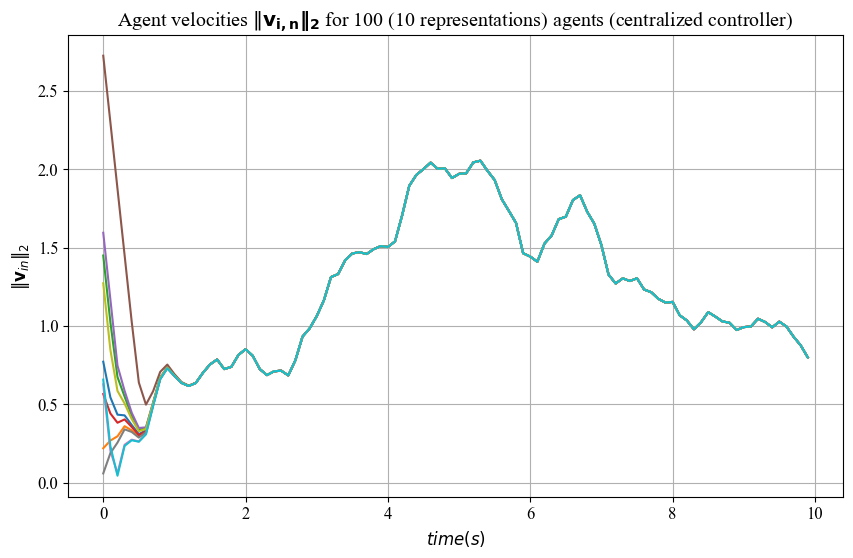

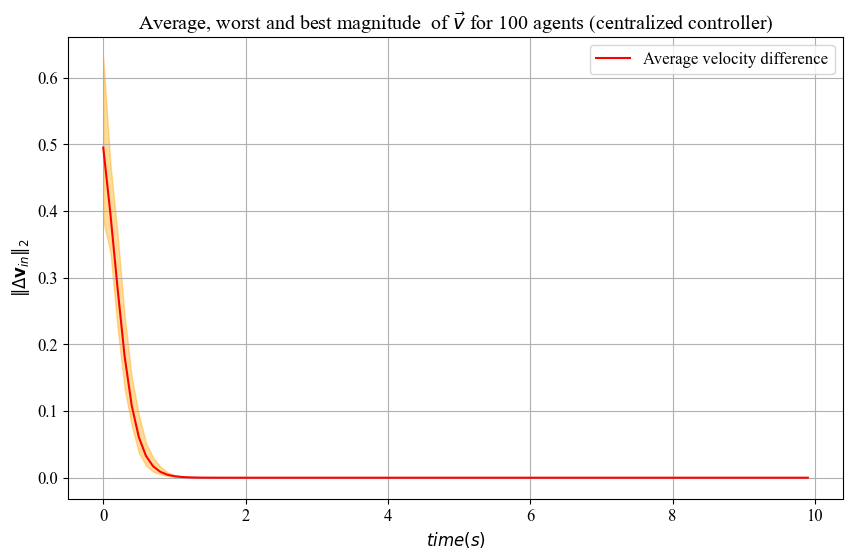

In [10]:
fig_fold='figures_part2/'
# Parameters
N=100 # number of agents
T= 10 # time (s)
# Part 1: Simulating centralized (optimal) controller

simulator = ConsensusSimulator(N, T)
controller = OptimalController()
ref_vel, est_vel, est_vels, biased_vels, accels = simulator.simulate(steps=100, controller=controller)

# Plots velocity for 100 agents
for i in range(0, 100, 10):
  plt.plot(np.arange(0, int(T),0.1), np.sqrt(est_vels[0,:,0, i]** 2 + est_vels[0,:,0, i]**2))

plt.title(r'Agent velocities $\|\bf{v}_{i,n}\|_2$ for ' + str(N)+ ' (10 representations)' + ' agents (centralized controller)')
plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|{\bf v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
# plt.savefig(fig_fold+'2-2.png', dpi=300)
plt.show()

# Plots average velocity difference between simulations

results_centralized = np.zeros((10, 100))

# for sim in range(10):
#   for t in range(100):
#     curr_step = np.sqrt(est_vels[sim,t,0, :]** 2 + est_vels[sim,t,1, :]**2)

#     results_centralized[sim, t] = np.sqrt((curr_step - curr_step.mean())**2).mean()

# for sim in range(5):
#   plt.plot(results_centralized[sim, :60], label = 'Simulation ' + str(sim + 1))

# plt.legend()
# plt.title(r'$|\Delta \vec{v}|$ as a function of iterations for centralized controller')
# plt.grid()
# plt.xlabel('$Iteration $')
# plt.ylabel(r'$\Delta |\vec{v}|$')
# plt.savefig(fig_fold+'centralized.png', dpi=300)
# plt.show()

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels[sim, t, 0, :] ** 2 + est_vels[sim, t, 1, :] ** 2)

    results_centralized[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val, max_val = [], []
for t in range(100):
  min_val.append(min(results_centralized[:, t]))
  max_val.append(max(results_centralized[:, t]))

plt.plot(np.arange(0, T, 0.1),results_centralized.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val, max_val, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  {\bf v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (centralized controller)')
# plt.savefig(fig_fold+'centralized.png', dpi=300)

plt.show()


## 2.1 Decentralized Consensus

The consensus problem we have just described becomes more interesting when formulated in a distributed setting. To do that, assume that agents are connected through a communication network. The network is described by a set of edges $(i,j) \in \mathcal{E}_n$ which induce the neighborhoods $\mathcal{N}_{in}$. With a graph restricting the exchange of information, the implementation of the optimal policy becomes impossible. 

An important point to repeat is that it becomes difficult to design appropriate controllers. Our goal is still the minimization of the cost but this is difficult to do with the partial information we are given. Faced with the impossibility of finding optimal controllers, we can resort to approximations. A natural idea is to forget about the fact that information is delayed and just evaluate the optimal policy with the information we have. We therefore define the averages
$$\bar{\mathbf{r}}_{jn}^k = \frac{1}{\#\left(\mathcal{N}_{in}^k\right)} \sum_{j\in\mathcal{N}_{in}^k} \mathbf{r}_{j (n-k)} ,$$
which represent the average velocity of the $k$-hop neighbors of node $i$ corrected by appropriated delays. Using these averages we can now approximate the controller as
$$\mathbf{u}_{in}^\dagger = \frac{-1}{T_s(1+\lambda)} \left( \mathbf{v}_{in} - \frac{1}{K}\sum_{k=1}^K \bar{\mathbf{r}}_{jn}^k \right) .$$

The controller defined by the above two equations is decentralized because it respects the information history structure. The values that are needed for implementation are available at node $i$ because they have been relayed through neighbors. That the controller can be implemented does not mean it will be any good. We are taking averages of out of date information. 

The fact that we are referring to $\mathbf{v}_{in}$ as the velocity of agent $i$ at time $n$ hints at moving agents. We are going to go there in the last section, but for the time being we are neglecting the fact that agents are moving. This is important because as agents move the communication network changes. This is not an issue except that it increases the cost of your simulation due to the necessity to recompute the communication graph. 

We can plot the average velocity difference as we did with the centralized controller. As one can observe, the velocity difference does not converge to zero in this case. 

In [9]:

class DistributedController(ConsensusController):
    def __init__(self, adjacency, K=1, sample_time=0.1, energy_weight=1):

        self.nSamples = adjacency.shape[0]
        self.nAgents = adjacency.shape[1]
        self.K = K
        self.neighbor_network = np.zeros((self.nSamples, K, self.nAgents, self.nAgents))
        self.num_neighbor = np.zeros((self.nSamples, K, 2, self.nAgents))

        for i in range(self.nSamples):
            for k in range(1, (K + 1)):
                inter_matrix = np.linalg.matrix_power(adjacency[i, :, :], k)
                inter_matrix[inter_matrix >= 1] = 1
                self.num_neighbor[i, k - 1, 0, :] = np.sum(inter_matrix, 1)
                self.num_neighbor[i, k - 1, 1, :] = np.sum(inter_matrix, 1)
                self.neighbor_network[i, k - 1, :, :] = inter_matrix

        self.sample_time = sample_time
        self.energy_weight = energy_weight

    def __call__(self, est_vel, biased_vel, step):
        # find the averages along 0,K neighborhoods and average them
        biased_means = np.zeros((self.nSamples, self.K, 2, self.nAgents))

        if step < (self.K - 1):
            for k in range(step):
                biased_means[:, k, :, :] = np.matmul(biased_vel[:, step - k, :, :], self.neighbor_network[:, k, :, :])
                biased_means[:, k, :, :] = biased_means[:, k, :, :] / self.num_neighbor[:, k, :, :]
        else:
            for k in range(self.K):
                biased_means[:, k, :, :] = np.matmul(biased_vel[:, step - k, :, :], self.neighbor_network[:, k, :, :])
                biased_means[:, k, :, :] = biased_means[:, k, :, :] / self.num_neighbor[:, k, :, :]
        biased_mean = np.mean(biased_means, 1)
        return (biased_mean - est_vel[:, step, :, :]) / (self.sample_time * (1 + self.energy_weight))


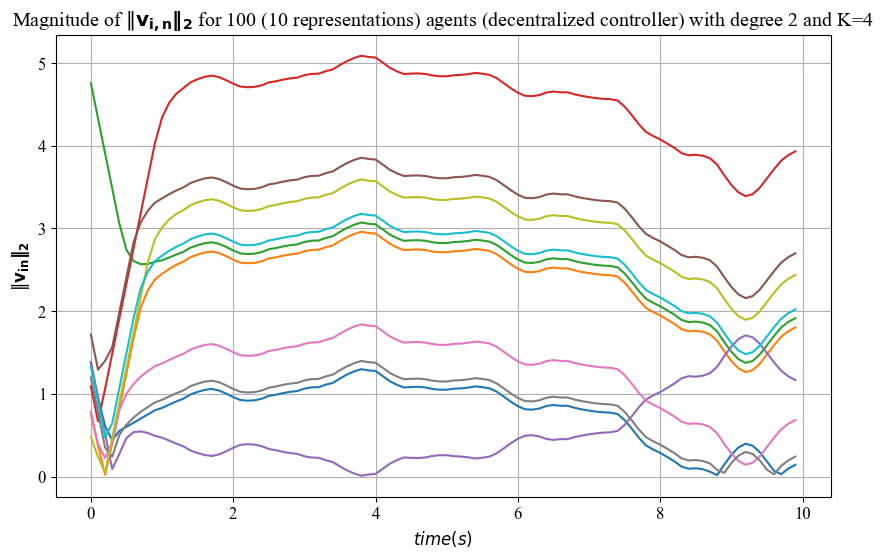

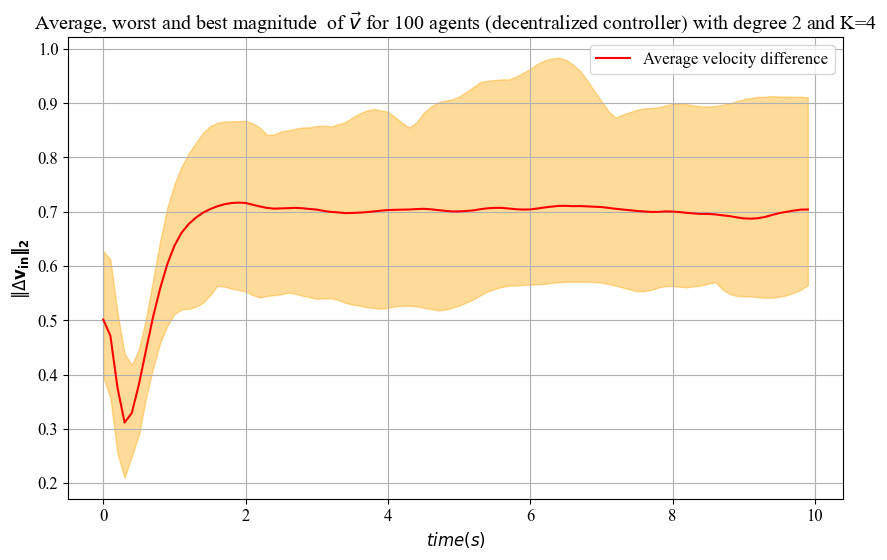

In [20]:
D = 2
K = 4
nSamples = 200
N = 100

com_network = np.zeros((nSamples, N, N))

# Networks
for i in range(nSamples):
  com_network[i, :, :], _ = agent_communication(100, 200, N, D)

simulator = ConsensusSimulator(N, nSamples, duration=10)
controller = DistributedController(com_network, K)
ref_vel, est_vel, est_vels, biased_vels, accels = simulator.simulate(steps=100, controller=controller)

for i in range(0, 100, 10):
  plt.plot(np.arange(0, 10,0.1), np.sqrt(est_vels[0, :, 0, i] ** 2 + est_vels[0, :, 0, i] ** 2))

plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|\bf{v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10, 6)
plt.title(r'Magnitude of $\|\bf{v}_{i,n}\|_2$ for ' + str(N)+ ' (10 representations)' + ' agents (decentralized controller) with degree ' + str (D)+' and K='+str(K))
plt.grid()
# plt.savefig(fig_fold+'2-4-3.png', dpi=300)
plt.show()

# Plotting average velocity differences

results_decentralized = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels[sim, t, 0, :] ** 2 + est_vels[sim, t, 1, :] ** 2)

    results_decentralized[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val_dec, max_val_dec = [], []
for t in range(100):
  min_val_dec.append(min(results_decentralized[:, t]))
  max_val_dec.append(max(results_decentralized[:, t]))

plt.plot(np.arange(0, T, 0.1),results_decentralized.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val_dec, max_val_dec, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  \bf{v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (decentralized controller) with degree ' + str (D)+' and K='+str(K))
# plt.savefig(fig_fold+'decentralized.png', dpi=300)

plt.show()


In [17]:
import numpy as np

def compute_avg_cost_from_vels(vels, avg_refs, Ts, lam):
    """
    vels    : (num_sims, T_steps, dim, N)
    avg_refs: (num_sims, T_steps, dim)
    Ts      : sampling time
    lam     : lambda in the cost

    Returns:
        avg_cost       : scalar, cost averaged over sims and time
        mean_cost_time : (T_steps-1,) cost vs time averaged over sims
    """
    num_sims, T_steps, dim, N = vels.shape

    # we can only define u_n for n = 0,...,T_steps-2 (need v_{n+1})
    costs = np.zeros((num_sims, T_steps - 1))

    for s in range(num_sims):
        for t in range(T_steps - 1):
            v_n    = vels[s, t]       # (dim, N)
            v_next = vels[s, t + 1]   # (dim, N)
            u_n    = (v_next - v_n) / Ts   # (dim, N)

            r_avg_n = avg_refs[s, t].reshape(dim, 1)  # (dim, 1)

            # tracking error term: 1/(2N) * sum_i ||v_i^n - r̄_n||^2
            err   = v_n - r_avg_n
            term1 = 0.5 / N * np.sum(np.linalg.norm(err, axis=0) ** 2)

            # control-energy term: λ/(2N) * sum_i ||Ts u_i^n||^2
            term2 = lam * 0.5 / N * np.sum((Ts * np.linalg.norm(u_n, axis=0)) ** 2)

            costs[s, t] = term1 + term2

    mean_cost_time = costs.mean(axis=0)
    avg_cost       = costs.mean()

    return avg_cost, mean_cost_time


In [21]:
# est_vels: (nSamples, T, 2, N)
# biased_vels: (nSamples, T, 2, N)

Ts=0.1
lam=1

avg_refs = biased_vels.mean(axis=3)   # average over agents -> (nSamples, T, 2)

avg_cost, mean_cost_time = compute_avg_cost_from_vels(
    est_vels, avg_refs, Ts=Ts, lam=lam
)

print("Average cost over 100 simulations:", avg_cost)


Average cost over 100 simulations: 1.3010105953609699


# 3 Learning Distributed Controllers

In Section 2 we explained the inherent complexity of decentralized control. In Section 2.1 we illustrated that these inherent complexities lead to important differences in practical performance. One can attribute the performance penalty to the fact that the decentralized policy forgets the fact that it is averaging information that can be out of date. This is true, but how can we correct for that? Say we choose to discount older information. This is a sensible idea but how do we choose discount factors? The problem is not that decentralized control becomes impossible to solve. But since finding the optimal controller *is* impossible, we are left to choose among many possible heuristics.

If we are settling for heuristics, there is no reason to overlook the use of learned heuristics. We use our models as a source of simulated data and fit a learned parametrization. This is the idea we described in Section 2. The goal of mimicking the optimal centralized policy means that, at least in principle, the learned heuristic can learn an optimal controller. This is something we give away in designed heuristics.

If we decide to settle for learned heuristics, our job as system designers is not complete. We should still choose the parametrization. Since we are considering a problem where a network plays a central role, the choice of parametrization is clear: We should choose graph filters and graph neural networks (GNNs). In the case of distributed systems there is a second, more important reason for us to use graph filters and GNNs: They can be implemented in a distributed manner while respecting the information structure of distributed control.

## 3.1 Distributed Implementation of Graph Filters and GNNs 

To explain the use of graph filters and GNNs in distributed systems we start by recalling our definition of MIMO graph filters as polynomials on the graph shift operator $\mathbf{S}$.

$$\mathbf{Z} = \sum_{k=0}^K \mathbf{S}^k \mathbf{X} \mathbf{H}_k .$$

In the case of distributed systems the matrix graph signal $\mathbf{X}$ is evolving over time index $n$. We therefore introduce a time varying version of the above equation in which the $k$th term of the polynomial multiplies the signal $\mathbf{X}_{n-k}$

$$\mathbf{Z}_n = \sum_{k=0}^K \mathbf{S}^k \mathbf{X}_{n-k} \mathbf{H}_k .$$

The reason for introducing this modification is that it is now possible to provide a distributed implementation that respects the information history structure from the agents available neighborhood. To see how this is done we express the above equation in terms of a modified diffusion sequence. This diffusion sequence is initialized as $\mathbf{Y}_{n0} = \mathbf{X}_n$ and its subsequent elements are computed recursively as

$$\mathbf{Y}_{nk} = \mathbf{S} \mathbf{Y}_{(n-1)(k-1)}.$$

Applying this definition recursively we have that $\mathbf{Y}_{nk} = \mathbf{S}^k \mathbf{Y}_{(n-k)0}$. Further recalling the initialization condition we have that $\mathbf{Y}_{(n-k)0} = \mathbf{X}_{n-k}$. Thus, $\mathbf{Y}_{nk} = \mathbf{S}^k \mathbf{X}_{n-k}$ and we have that the filter can be equivalently written as a summation of elements of the diffusion sequence,

$$\mathbf{Z}_n = \sum_{k=0}^K \mathbf{Y}_{nk} \mathbf{H}_k$$

To show that we can implement the above equation in a distributed manner, it suffices if we show that each of the $\mathbf{Y}_{nk}$ terms can be evaluated through local computation exchanges. To see that this is true recall that the shift operator shares the sparsity pattern of the graph. Thus, when we look at the computation of the $i$ th entry of $\mathbf{Y}_{nk}$ we can write

$$\Big[\,\mathbf{Y}_{nk}\,\Big]_{i} = \sum_{j\in \mathcal{N}_{ni}} \Big[\,\mathbf{S} \,\Big]_{ij} \times \Big[\, \mathbf{Y}_{(n-1)(k-1)} \,\Big]_{j} \,.$$

According to the above equation, node $i$ can compute the $i$ th entry of $\mathbf{Y}_{nk}$ if it receives information from neighboring agents $j$ about the values of the $j$ th entries of the $\mathbf{Y}_{(n-1)(k-1)}$. This is something that is available to node $i$ because it can be communicated from its neighboring agents $j$. These are, by definition, the agents with which $i$ can communicate.

If a graph filter can be implemented in a distributed manner, a GNN can be as well. This is because the nonlinearity is pointwise and can be implemented locally. Having seen that a GNN can respect the information structure of distributed systems, we can use them as learning parametrizations in decentralized control. This is the goal of the next question. 

First we implement distributed graph filter and GNN.

In [17]:
def LSIGF_DB(h, S, x, b=None):

    F = h.shape[0]
    E = h.shape[1]
    K = h.shape[2]
    G = h.shape[3]
    B = S.shape[0]
    T = S.shape[1]
    N = S.shape[3]

    x = x.reshape([B, T, 1, G, N]).repeat(1, 1, E, 1, 1)
    z = x.reshape([B, T, 1, E, G, N])
    for k in range(1 ,K):
        x, _ = torch.split(x, [ T -1, 1], dim = 1)
        zeroRow = torch.zeros(B, 1, E, G, N, dtype=x.dtype ,device=x.device)
        x = torch.cat((zeroRow, x), dim = 1)
        x = torch.matmul(x, S)
        xS = x.reshape(B, T, 1, E, G, N)
        z = torch.cat((z, xS), dim = 2)

    z = z.permute(0, 1, 5, 3, 2, 4)
    z = z.reshape(B, T, N, E* K * G)
    h = h.reshape(F, E * K * G)
    h = h.permute(1, 0)
    y = torch.matmul(z, h)
    y = y.permute(0, 1, 3, 2)
    if b is not None:
        y = y + b

    return y


class GraphFilter_DB(nn.Module):

    def __init__(self, G, F, K, E=1, bias=True):

        super().__init__()

        self.G = G
        self.F = F
        self.K = K
        self.E = E
        self.S = None
        self.weight = nn.parameter.Parameter(torch.Tensor(F, E, K, G))
        if bias:
            self.bias = nn.parameter.Parameter(torch.Tensor(F, 1))
        else:
            self.register_parameter('bias', None)
        # Initialize parameters
        self.reset_parameters()

    def reset_parameters(self):

        stdv = 1. / math.sqrt(self.G * self.K)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def addGSO(self, S):

        assert len(S.shape) == 5
        assert S.shape[2] == self.E
        self.N = S.shape[3]
        assert S.shape[4] == self.N
        self.S = S

    def forward(self, x):

        assert len(x.shape) == 4
        B = x.shape[0]
        assert self.S.shape[0] == B
        T = x.shape[1]
        assert self.S.shape[1] == T
        assert x.shape[3] == self.N
        u = LSIGF_DB(self.weight, self.S, x, self.bias)
        return u


class LocalGNN_DB(nn.Module):

    def __init__(self,
                 dimNodeSignals, nFilterTaps, bias,
                 nonlinearity,
                 dimReadout,
                 dimEdgeFeatures):

        super().__init__()

        self.L = len(nFilterTaps)
        self.F = dimNodeSignals
        self.K = nFilterTaps
        self.E = dimEdgeFeatures
        self.bias = bias
        self.sigma = nonlinearity
        self.dimReadout = dimReadout

        gfl0 = []
        for l in range(self.L):
            gfl0.append(GraphFilter_DB(self.F[l], self.F[l + 1], self.K[l],
                                       self.E, self.bias))
            gfl0.append(self.sigma())
        self.GFL0 = nn.Sequential(*gfl0)

        fc0 = []
        if len(self.dimReadout) > 0:
            fc0.append(nn.Linear(self.F[-1], dimReadout[0], bias=self.bias))
            for l in range(len(dimReadout) - 1):
                fc0.append(self.sigma())
                fc0.append(nn.Linear(dimReadout[l], dimReadout[l + 1],
                                     bias=self.bias))

        self.Readout0 = nn.Sequential(*fc0)

    def splitForward(self, x, S):

        assert len(S.shape) == 4 or len(S.shape) == 5
        if len(S.shape) == 4:
            S = S.unsqueeze(2)
        for l in range(self.L):
            self.GFL0[2 * l].addGSO(S)
        yGFL0 = self.GFL0(x)
        y = yGFL0.permute(0, 1, 3, 2)
        y = self.Readout0(y)

        return y.permute(0, 1, 3, 2), yGFL0
        # B x T x dimReadout[-1] x N, B x T x dimFeatures[-1] x N

    def forward(self, x, S):

        output, _ = self.splitForward(x, S)

        return output



class Model:

    def __init__(self,
                 architecture,
                 loss,
                 optimizer,
                 trainer,
                 device, name, saveDir):

        self.archit = architecture
        self.nParameters = 0
        for param in list(self.archit.parameters()):
            if len(param.shape) > 0:
                thisNParam = 1
                for p in range(len(param.shape)):
                    thisNParam *= param.shape[p]
                self.nParameters += thisNParam
            else:
                pass
        self.loss = loss
        self.optim = optimizer
        self.trainer = trainer
        self.device = device
        self.name = name
        self.saveDir = saveDir

    def train(self, simulator, ref_vel, est_vel, est_vels, biased_vels, accels, com_network, nEpochs,
              batchSize, positions:Optional[np.ndarray]=None, mobility=False, collision=False):
        self.trainer = self.trainer(self,simulator,  ref_vel, est_vel, est_vels, biased_vels, accels, com_network,
                                    nEpochs, batchSize, positions)  # Here
        return self.trainer.train(mobility, collision)

    def save(self, label='', **kwargs):
        if 'saveDir' in kwargs.keys():
            saveDir = kwargs['saveDir']
        else:
            saveDir = self.saveDir
        saveModelDir = os.path.join(saveDir, 'savedModels')
        # Create directory savedModels if it doesn't exist yet:
        if not os.path.exists(saveModelDir):
            os.makedirs(saveModelDir)
        saveFile = os.path.join(saveModelDir, self.name)
        torch.save(self.archit.state_dict(), saveFile + 'Archit' + label + '.ckpt')
        torch.save(self.optim.state_dict(), saveFile + 'Optim' + label + '.ckpt')

    def load(self, label='', **kwargs):
        if 'loadFiles' in kwargs.keys():
            (architLoadFile, optimLoadFile) = kwargs['loadFiles']
        else:
            saveModelDir = os.path.join(self.saveDir, 'savedModels')
            architLoadFile = os.path.join(saveModelDir,
                                          self.name + 'Archit' + label + '.ckpt')
            optimLoadFile = os.path.join(saveModelDir,
                                         self.name + 'Optim' + label + '.ckpt')
        self.archit.load_state_dict(torch.load(architLoadFile))
        self.optim.load_state_dict(torch.load(optimLoadFile))

Then we implement the training loop, with logging and checkpoint saving. Note that this will be reused for all the rest of the lab to avoid duplicates code.

In [11]:
class Trainer:

    def __init__(self, model, simulator, ref_vel, est_vel, est_vels, biased_vels, accels, S, nEpochs, batchSize, positions:Optional[np.ndarray]=None):

        self.model = model
        self.positions = positions
        self.est_vel = est_vel
        self.ref_vel = ref_vel
        self.est_vels = est_vels
        self.biased_vels = biased_vels
        self.accels = accels
        self.S = S
        self.nTrain = 200
        self.nTest = 20
        self.nValid = 20
        self.nEpochs = nEpochs
        self.simulator = simulator
        self.validationInterval = self.nTrain // batchSize

        if self.nTrain < batchSize:
            self.nBatches = 1
            self.batchSize = [self.nTrain]
        elif self.nTrain % batchSize != 0:
            self.nBatches = np.ceil(self.nTrain / batchSize).astype(np.int64)
            self.batchSize = [batchSize] * self.nBatches
            while sum(batchSize) != self.nTrain:
                self.batchSize[-1] -= 1
        else:
            self.nBatches = np.int64(self.nTrain / batchSize)
            self.batchSize = [batchSize] * self.nBatches

        self.batchIndex = np.cumsum(self.batchSize).tolist()
        self.batchIndex = [0] + self.batchIndex


    def train(self, mobility: bool = False, collision: bool = False):
        """Mobility and collision are optional parameters to be used in the training loop.
        Mobility means the communication graph is time-varying, and collision means we include collision avoidance penalty."""

        nTrain = self.nTrain
        thisArchit = self.model.archit
        thisLoss = self.model.loss
        thisOptim = self.model.optim
        thisDevice = self.model.device
        epoch = 0
        if collision:
            pos_train = self.positions[0:self.nTrain]
            posDiff, posDistSq = computeDifferences(pos_train)
            com_networks = copy.deepcopy(self.S[0:self.nTrain])
            com_networks = (np.abs(com_networks) > 1e-9).astype(self.positions.dtype)
            com_networks = np.expand_dims(com_networks, 2)
            posDiff = posDiff * com_networks
            statePos = np.sum(posDiff, axis=4)
            xTrainAll = np.concatenate(
                (self.est_vels[0:self.nTrain].copy(), self.biased_vels[0:self.nTrain].copy(), statePos), axis=2)
        else:
            xTrainAll = np.concatenate((self.est_vels[0:self.nTrain].copy(), self.biased_vels[0:self.nTrain].copy()),
                                    axis=2)
        yTrainAll = self.accels[0:self.nTrain].copy()
        StrainAll = self.S[0:self.nTrain].copy()

        while epoch < self.nEpochs:

            randomPermutation = np.random.permutation(nTrain)
            idxEpoch = [int(i) for i in randomPermutation]
            batch = 0

            while batch < self.nBatches:

                thisBatchIndices = idxEpoch[self.batchIndex[batch]: self.batchIndex[batch + 1]]
                xTrain = xTrainAll[thisBatchIndices]
                yTrain = yTrainAll[thisBatchIndices]
                Strain = StrainAll[thisBatchIndices]

                xTrain = torch.tensor(xTrain, device=thisDevice)
                Strain = torch.tensor(Strain, device=thisDevice)
                yTrain = torch.tensor(yTrain, device=thisDevice)

                startTime = datetime.datetime.now()
                thisArchit.zero_grad()
                yHatTrain = thisArchit(xTrain, Strain)
                lossValueTrain = thisLoss(yHatTrain, yTrain)
                lossValueTrain.backward()
                thisOptim.step()
                endTime = datetime.datetime.now()
                timeElapsed = abs(endTime - startTime).total_seconds()
                del xTrain
                del Strain
                del yTrain
                del lossValueTrain

                # \\\\\\\
                # \\\ VALIDATION
                # \\\\\\\

                if (epoch * self.nBatches + batch) % self.validationInterval == 0:

                    startTime = datetime.datetime.now()
                    ref_vel = self.ref_vel[220:240]
                    est_vel = self.est_vel[220:240]
                    if mobility is False and collision is False:
                        _, _, est_vels_valid, biased_vels_valid, accels_valid = self.simulator.computeTrajectory(thisArchit,
                                                                                                                 ref_vel,
                                                                                                                 est_vel,
                                                                                                                 100)
                    elif mobility is True and collision is False:
                        _, _, est_vels_valid, biased_vels_valid, accels_valid = self.simulator.computeTrajectory_pos(thisArchit,
                                                                                                                 self.positions[220:240],
                                                                                                                 ref_vel,
                                                                                                                 est_vel,
                                                                                                                 100)
                    elif collision is True:
                        _, _, est_vels_valid, biased_vels_valid, accels_valid, _= self.simulator.computeTrajectory_pos_collision(thisArchit,
                                                                                                                 self.positions[220:240],
                                                                                                                 ref_vel,
                                                                                                                 est_vel,
                                                                                                                 100)
                    accValid = self.simulator.cost(est_vels_valid, biased_vels_valid, accels_valid)
                    endTime = datetime.datetime.now()
                    timeElapsed = abs(endTime - startTime).total_seconds()

                    print("\t(E: %2d, B: %3d) %8.4f - %6.4fs" % (
                        epoch + 1, batch + 1,
                        accValid,
                        timeElapsed), end=' ')
                    print("[VALIDATION] \n", end='')

                    if epoch == 0 and batch == 0:
                        bestScore = accValid
                        bestEpoch, bestBatch = epoch, batch
                        self.model.save(label='Best')
                        # Start the counter
                    else:
                        thisValidScore = accValid
                        if thisValidScore < bestScore:
                            bestScore = thisValidScore
                            bestEpoch, bestBatch = epoch, batch
                            print("\t=> New best achieved: %.4f" % (bestScore))
                            self.model.save(label='Best')
                    del ref_vel
                    del est_vel
                batch += 1
            epoch += 1

        self.model.save(label='Last')
        #################
        # TRAINING OVER #
        #################
        if self.nEpochs == 0:
            self.model.save(label='Best')
            self.model.save(label='Last')
            print("\nWARNING: No training. Best and Last models are the same.\n")
        self.model.load(label='Best')
        if self.nEpochs > 0:
            print("\t=> Best validation achieved (E: %d, B: %d): %.4f" % (
                bestEpoch + 1, bestBatch + 1, bestScore))

Finally put everything together

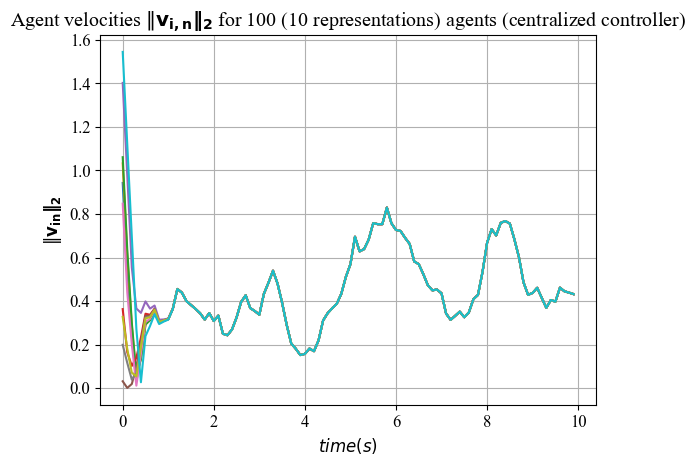

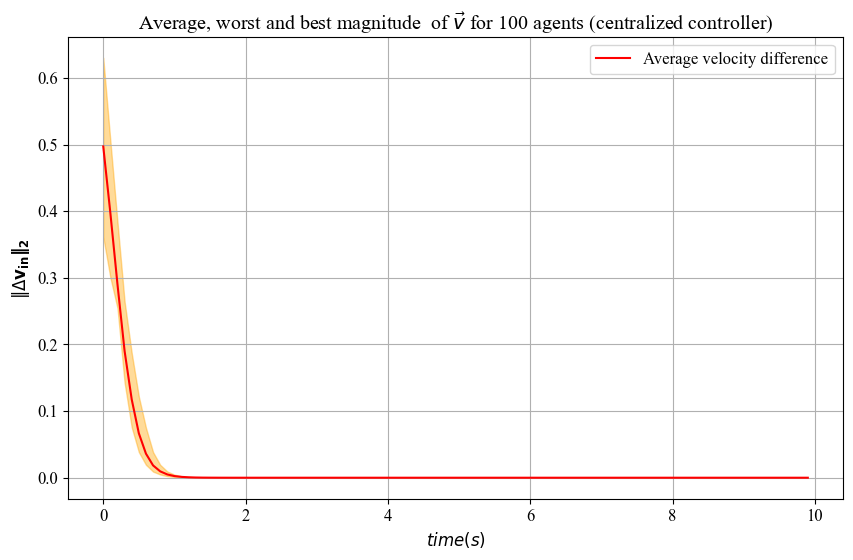

	(E:  1, B:   1) 251.8394 - 6.7043s [VALIDATION] 
	=> Best validation achieved (E: 1, B: 1): 251.8394
264.3139011118548


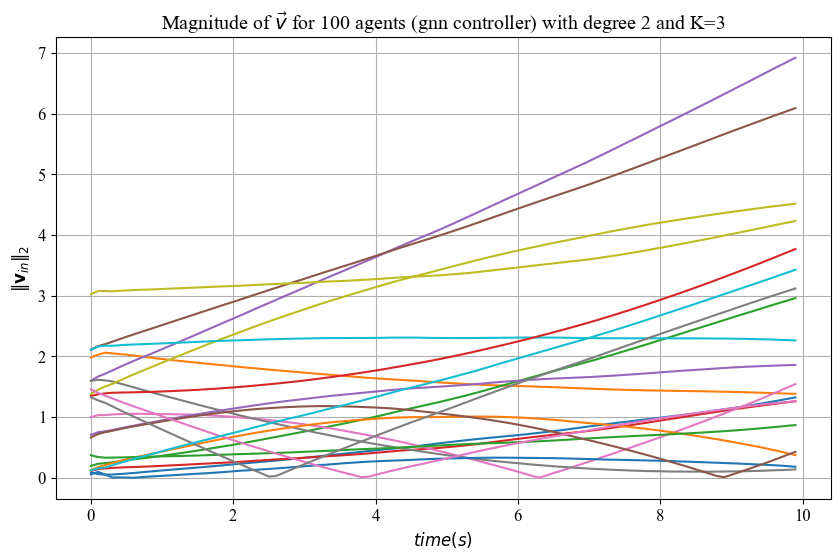

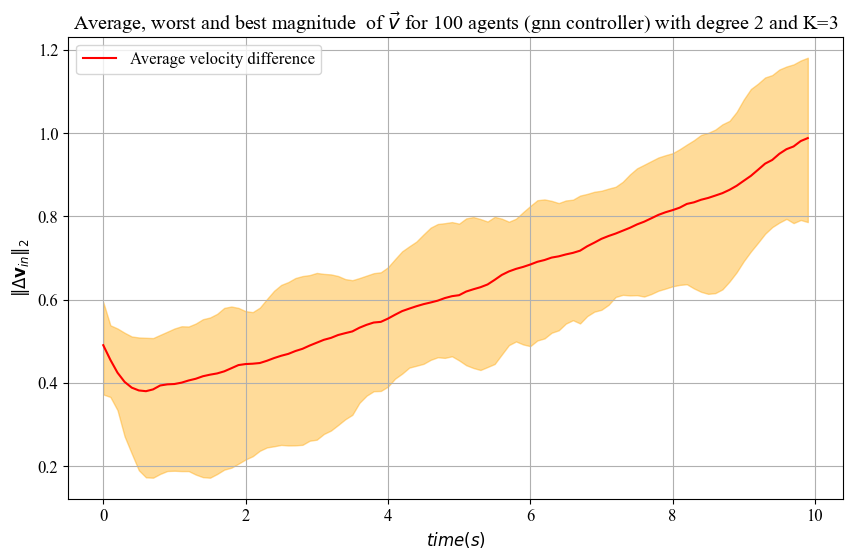

In [19]:
# %% Parameters
D = 2
K = 3
nSamples = 240
N = 100
T=10
step = int(T/0.1)
fig_fold = 'figures_part3/'

# GNN
nEpochs = 1  # Number of epochs
batchSize = 20  # Batch size
learningRate = 0.00025
beta1 = 0.9
beta2 = 0.999

network = np.zeros((nSamples, N, N))
com_network = np.zeros((nSamples, step, N, N))

# %% Networks
for i in range(nSamples):
    network[i, :, :], com_network[i, 0, :, :] = agent_communication(100, 200, N, D)
    for t in range(1, step):
        com_network[i, t, :, :] = deepcopy(com_network[i, 0, :, :])

# %% Dataset generation
optimal_controller = OptimalController()
simulator = ConsensusSimulator(N, nSamples)

ref_vel, est_vel, est_vels, biased_vels, accels = simulator.simulate(100, optimal_controller)

# Plots velocity for 100 agents
for i in range(0, 100, 10):
  plt.plot(np.arange(0, int(T),0.1), np.sqrt(est_vels[0,:,0, i]** 2 + est_vels[0,:,0, i]**2))

plt.title(r'Agent velocities $\|\bf{v}_{i,n}\|_2$ for ' + str(N)+ ' (10 representations)' + ' agents (centralized controller)')
plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|\bf{v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
# plt.savefig(fig_fold+'2-2.png', dpi=300)
plt.show()

# Plots average velocity difference between simulations
results_centralized = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels[sim, t, 0, :] ** 2 + est_vels[sim, t, 1, :] ** 2)

    results_centralized[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val, max_val = [], []
for t in range(100):
  min_val.append(min(results_centralized[:, t]))
  max_val.append(max(results_centralized[:, t]))

plt.plot(np.arange(0, T, 0.1),results_centralized.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val, max_val, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  \bf{v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (centralized controller)')
# plt.savefig(fig_fold+'centralized.png', dpi=300)

plt.show()

# %% Training
thisFilename = 'flockingGNN'
saveDirRoot = 'experiments'
saveDir = os.path.join(saveDirRoot, thisFilename)
today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
saveDir = saveDir + '-%03d-' + today
# Create directory
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

#   PyTorch seeds
torchState = torch.get_rng_state()
torchSeed = torch.initial_seed()
#   Numpy seeds
numpyState = np.random.RandomState().get_state()



hParamsLocalGNN = {}  # Hyperparameters (hParams) for the Local GNN
hParamsLocalGNN['name'] = 'LocalGNN'
hParamsLocalGNN['archit'] = LocalGNN_DB
hParamsLocalGNN['device'] = 'cuda:0' \
    if (True and torch.cuda.is_available()) \
    else 'cpu'
hParamsLocalGNN['dimNodeSignals'] = [4, 64, 2]  # Features per layer
hParamsLocalGNN['nFilterTaps'] = [4, 1]  # Number of filter taps
hParamsLocalGNN['bias'] = True
hParamsLocalGNN['nonlinearity'] = nn.Tanh
hParamsLocalGNN['dimReadout'] = []
hParamsLocalGNN['dimEdgeFeatures'] = 1

if torch.cuda.is_available():
    torch.cuda.empty_cache()
hParamsDict = deepcopy(hParamsLocalGNN)
thisName = hParamsDict.pop('name')
callArchit = hParamsDict.pop('archit')
thisDevice = hParamsDict.pop('device')

##############
# PARAMETERS #
##############

thisArchit = callArchit(**hParamsDict)
thisArchit.to(thisDevice)
thisOptim = optim.Adam(thisArchit.parameters(), lr=learningRate, betas=(beta1, beta2))
thisLossFunction = nn.MSELoss()
GraphNNs = Model(thisArchit, thisLossFunction, thisOptim, Trainer, thisDevice, thisName, saveDir)

batchsize = 5
# Train
GraphNNs.train(simulator, ref_vel, est_vel, est_vels, biased_vels, accels, com_network, nEpochs, batchSize)

# Test
ref_vel_test = ref_vel[200:220]
est_vel_test = est_vel[200:220]
_, _, est_vels_valid, biased_vels_valid, accels_valid = simulator.computeTrajectory(GraphNNs.archit, ref_vel_test,
                                                                                    est_vel_test, 100)
cost = simulator.cost(est_vels_valid, biased_vels_valid, accels_valid)
print(cost)

for i in range(0, 100, 5):
  plt.plot(np.arange(0, T, 0.1), np.sqrt(est_vels_valid[0, :, 0, i] ** 2 + est_vels_valid[0, :, 0, i] ** 2))

plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|{\bf v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10, 6)
plt.title(r'Magnitude of $\vec{v}$ for ' + str(N)+ ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
plt.grid()
# plt.savefig(fig_fold+'3.png', dpi=300)
plt.figure()

results_gnn = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels_valid[sim, t, 0, :] ** 2 + est_vels[sim, t, 1, :] ** 2)

    results_gnn[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val_dec, max_val_dec = [], []
for t in range(100):
  min_val_dec.append(min(results_gnn[:, t]))
  max_val_dec.append(max(results_gnn[:, t]))

plt.plot(np.arange(0, T, 0.1),results_gnn.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val_dec, max_val_dec, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  {\bf v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
# plt.savefig(fig_fold+'gnn.png', dpi=300)

plt.show()

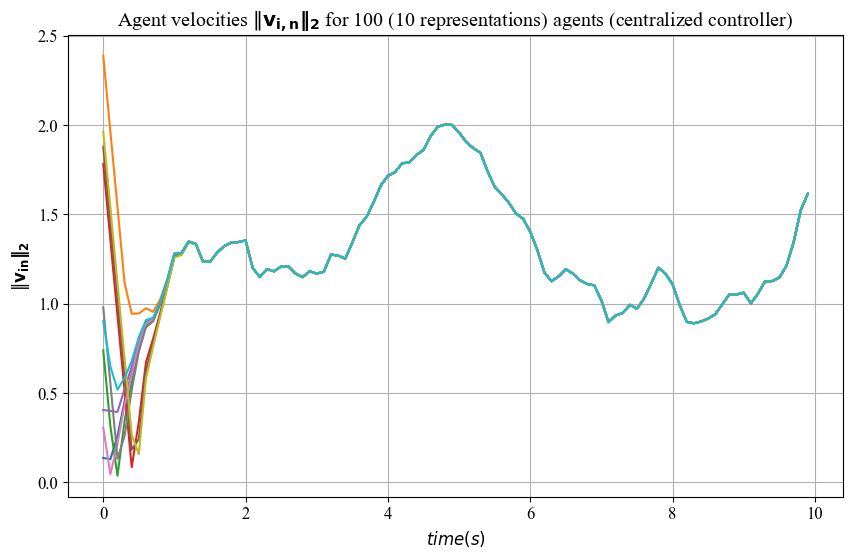

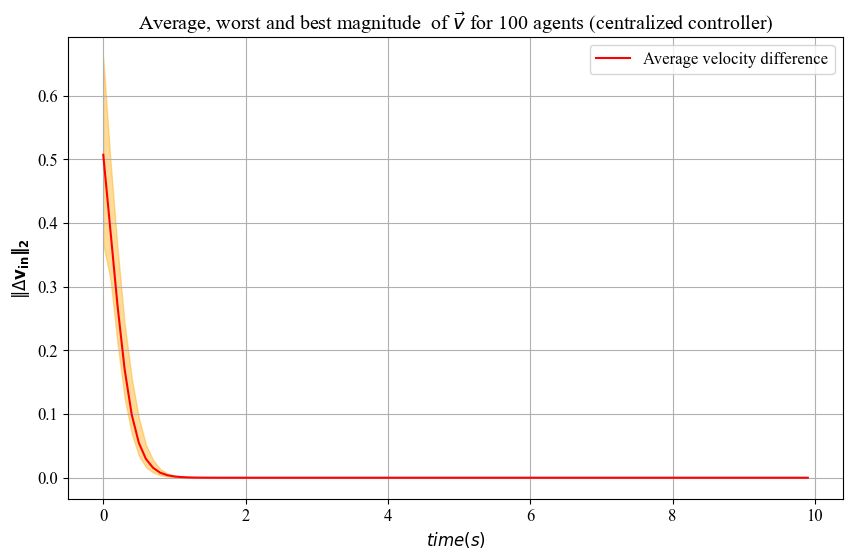

	(E:  1, B:   1) 243.8671 - 5.4545s [VALIDATION] 
	(E:  2, B:   1) 199.0827 - 5.1156s [VALIDATION] 
	=> New best achieved: 199.0827
	(E:  3, B:   1) 152.2434 - 8.1571s [VALIDATION] 
	=> New best achieved: 152.2434
	(E:  4, B:   1) 145.7325 - 8.2755s [VALIDATION] 
	=> New best achieved: 145.7325
	(E:  5, B:   1) 137.2372 - 7.9909s [VALIDATION] 
	=> New best achieved: 137.2372
	(E:  6, B:   1) 136.6321 - 15.9066s [VALIDATION] 
	=> New best achieved: 136.6321
	(E:  7, B:   1) 132.4310 - 17.5586s [VALIDATION] 
	=> New best achieved: 132.4310
	(E:  8, B:   1)  95.8169 - 18.1024s [VALIDATION] 
	=> New best achieved: 95.8169
	(E:  9, B:   1)  97.7179 - 13.2258s [VALIDATION] 
	(E: 10, B:   1) 105.3525 - 10.1916s [VALIDATION] 
	(E: 11, B:   1) 103.7903 - 10.1196s [VALIDATION] 
	(E: 12, B:   1) 105.1691 - 10.2642s [VALIDATION] 
	(E: 13, B:   1) 107.7633 - 10.2947s [VALIDATION] 
	(E: 14, B:   1)  85.1637 - 10.1032s [VALIDATION] 
	=> New best achieved: 85.1637
	(E: 15, B:   1) 100.7594 - 10.4810s 

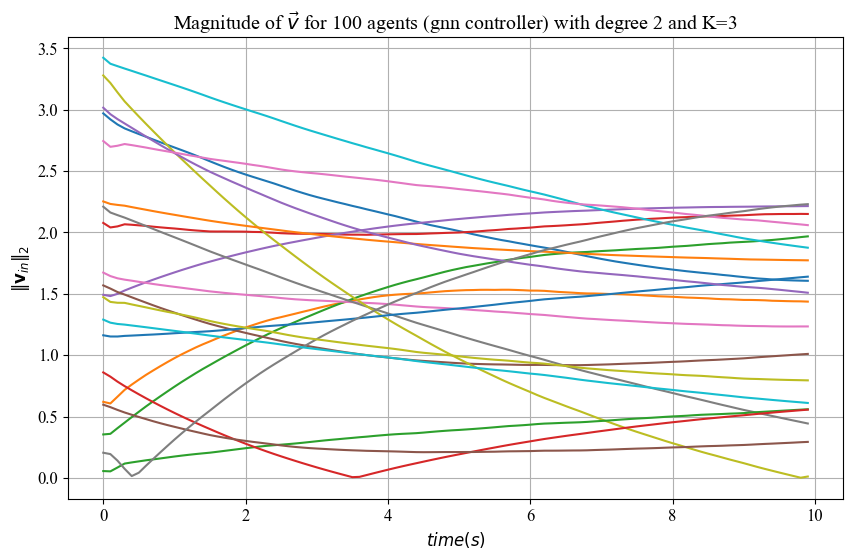

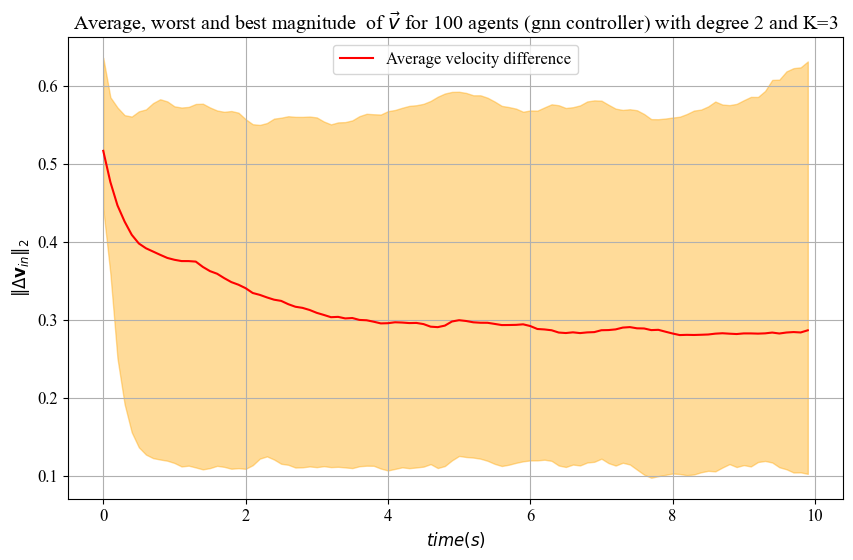

In [23]:
# %% Parameters
D = 2
K = 3
nSamples = 240
N = 100
T=10
step = int(T/0.1)
fig_fold = 'figures_part3/'

# GNN
nEpochs = 50  # Number of epochs
batchSize = 20  # Batch size
learningRate = 0.00025
beta1 = 0.9
beta2 = 0.999

network = np.zeros((nSamples, N, N))
com_network = np.zeros((nSamples, step, N, N))

# %% Networks
for i in range(nSamples):
    network[i, :, :], com_network[i, 0, :, :] = agent_communication(100, 200, N, D)
    for t in range(1, step):
        com_network[i, t, :, :] = deepcopy(com_network[i, 0, :, :])

# %% Dataset generation
optimal_controller = OptimalController()
simulator = ConsensusSimulator(N, nSamples)

ref_vel, est_vel, est_vels, biased_vels, accels = simulator.simulate(100, optimal_controller)

# Plots velocity for 100 agents
for i in range(0, 100, 10):
  plt.plot(np.arange(0, int(T),0.1), np.sqrt(est_vels[0,:,0, i]** 2 + est_vels[0,:,0, i]**2))

plt.title(r'Agent velocities $\|\bf{v}_{i,n}\|_2$ for ' + str(N)+ ' (10 representations)' + ' agents (centralized controller)')
plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|\bf{v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10,6)
plt.grid()
# plt.savefig(fig_fold+'2-2.png', dpi=300)
plt.show()

# Plots average velocity difference between simulations
results_centralized = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels[sim, t, 0, :] ** 2 + est_vels[sim, t, 1, :] ** 2)

    results_centralized[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val, max_val = [], []
for t in range(100):
  min_val.append(min(results_centralized[:, t]))
  max_val.append(max(results_centralized[:, t]))

plt.plot(np.arange(0, T, 0.1),results_centralized.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val, max_val, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  \bf{v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (centralized controller)')
# plt.savefig(fig_fold+'centralized.png', dpi=300)

plt.show()

# %% Training
thisFilename = 'flockingGNN'
saveDirRoot = 'experiments'
saveDir = os.path.join(saveDirRoot, thisFilename)
today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
saveDir = saveDir + '-%03d-' + today
# Create directory
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

#   PyTorch seeds
torchState = torch.get_rng_state()
torchSeed = torch.initial_seed()
#   Numpy seeds
numpyState = np.random.RandomState().get_state()



hParamsLocalGNN = {}  # Hyperparameters (hParams) for the Local GNN
hParamsLocalGNN['name'] = 'LocalGNN'
hParamsLocalGNN['archit'] = LocalGNN_DB
hParamsLocalGNN['device'] = 'cuda:0' \
    if (True and torch.cuda.is_available()) \
    else 'cpu'
hParamsLocalGNN['dimNodeSignals'] = [4, 64, 2]  # Features per layer
hParamsLocalGNN['nFilterTaps'] = [4, 1]  # Number of filter taps
hParamsLocalGNN['bias'] = True
hParamsLocalGNN['nonlinearity'] = nn.Tanh
hParamsLocalGNN['dimReadout'] = []
hParamsLocalGNN['dimEdgeFeatures'] = 1

if torch.cuda.is_available():
    torch.cuda.empty_cache()
hParamsDict = deepcopy(hParamsLocalGNN)
thisName = hParamsDict.pop('name')
callArchit = hParamsDict.pop('archit')
thisDevice = hParamsDict.pop('device')

##############
# PARAMETERS #
##############

thisArchit = callArchit(**hParamsDict)
thisArchit.to(thisDevice)
thisOptim = optim.Adam(thisArchit.parameters(), lr=learningRate, betas=(beta1, beta2))
thisLossFunction = nn.MSELoss()
GraphNNs = Model(thisArchit, thisLossFunction, thisOptim, Trainer, thisDevice, thisName, saveDir)

batchsize = 5
# Train
GraphNNs.train(simulator, ref_vel, est_vel, est_vels, biased_vels, accels, com_network, nEpochs, batchSize)

# Test
ref_vel_test = ref_vel[200:220]
est_vel_test = est_vel[200:220]
_, _, est_vels_valid, biased_vels_valid, accels_valid = simulator.computeTrajectory(GraphNNs.archit, ref_vel_test,
                                                                                    est_vel_test, 100)
cost = simulator.cost(est_vels_valid, biased_vels_valid, accels_valid)
print(cost)

for i in range(0, 100, 5):
  plt.plot(np.arange(0, T, 0.1), np.sqrt(est_vels_valid[0, :, 0, i] ** 2 + est_vels_valid[0, :, 0, i] ** 2))

plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|{\bf v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10, 6)
plt.title(r'Magnitude of $\vec{v}$ for ' + str(N)+ ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
plt.grid()
# plt.savefig(fig_fold+'3.png', dpi=300)
plt.figure()

results_gnn = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels_valid[sim, t, 0, :] ** 2 + est_vels[sim, t, 1, :] ** 2)

    results_gnn[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val_dec, max_val_dec = [], []
for t in range(100):
  min_val_dec.append(min(results_gnn[:, t]))
  max_val_dec.append(max(results_gnn[:, t]))

plt.plot(np.arange(0, T, 0.1),results_gnn.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val_dec, max_val_dec, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  {\bf v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
# plt.savefig(fig_fold+'gnn.png', dpi=300)

plt.show()

We can see that GNNs close the gap between centralized controllers that cannot be implemented in practice with decentralized controllers. GNNs work because they learn the relationships between hops in the network, and are stable to perturbations and equivariant to relabeling. These two last properties will be studied in the next two sections.

In [24]:
# ========= CHECK THESE TWO VARIABLE NAMES FIRST =========
# Ask Codex: 
# “What is the variable name storing the GNN rollout velocities?”
# “What is the variable name storing the biased reference rollouts for the GNN?”
#
# In most ESE5140 labs, they are:
#    est_vels_valid      = (nSims, T, 2, N)
#    biased_vels_valid   = (nSims, T, 2, N)
# =========================================================

vels_gnn  = est_vels_valid        # <-- CONFIRM NAME WITH CODEX
refs_gnn  = biased_vels_valid     # <-- CONFIRM NAME WITH CODEX

# Compute average references across agents (shape becomes (nSims, T, 2))
avg_refs_gnn = refs_gnn.mean(axis=3)

# ========= Cost function (same as Section 2) =========

import numpy as np

def compute_avg_cost_from_vels(vels, avg_refs, Ts, lam):
    """
    vels    : (num_sims, T_steps, dim, N)
    avg_refs: (num_sims, T_steps, dim)
    Ts      : sampling time used in the simulation (usually 0.1)
    lam     : lambda in the controller cost (usually 1.0)
    """
    num_sims, T_steps, dim, N = vels.shape
    costs = np.zeros((num_sims, T_steps - 1))

    for s in range(num_sims):
        for t in range(T_steps - 1):
            v_n    = vels[s, t]       # (dim, N)
            v_next = vels[s, t + 1]
            u_n    = (v_next - v_n) / Ts

            r_avg_n = avg_refs[s, t].reshape(dim, 1)

            # tracking error term
            err   = v_n - r_avg_n
            term1 = 0.5 / N * np.sum(np.linalg.norm(err, axis=0)**2)

            # control energy
            term2 = lam * 0.5 / N * np.sum((Ts * np.linalg.norm(u_n, axis=0))**2)

            costs[s, t] = term1 + term2

    return costs.mean(), costs.mean(axis=0)

# ========= Use the function for the GNN controller =========

Ts  = 0.1     # confirm if your notebook defines Ts elsewhere
lam = 1.0     # confirm if your centralized controller used lam=1

avg_cost_gnn, mean_cost_time_gnn = compute_avg_cost_from_vels(
    vels_gnn,
    avg_refs_gnn,
    Ts,
    lam
)

print("Average cost over 100 simulations (GNN):", avg_cost_gnn)


Average cost over 100 simulations (GNN): 0.8599988437749361


## 4 Agent Mobility

In this section, we modify the problem to incorporate agent mobility. Denote as $\mathbf{p}_{in}$ the position of agent $i$ at time $n$ and augment the dynamical model to incorporate the dynamics that control this variable,

$$\mathbf{p}_{i(n+1)} = \mathbf{p}_{in} + T_s \mathbf{v}_{in} + (T_s^2/2) \mathbf{u}_{in}.$$

When we incorporate agent mobility the first aspect of the problem that changes is that the network is no longer fixed. As agents move, their set of nearest neighbors change. This is consistent with our generic problem description. To make our graph filters consistent with a time varying network we just need to modify the definition of the diffusion sequence to take time varying networks into consideration. We thus replace the previous equation by $\mathbf{Y}_{nk} = \mathbf{S}_n \mathbf{Y}_{(n-1)(k-1)}$ where $\mathbf{S}_n$ is the shift operator of the communication network at time $n$.

In this part of the lab we are going to run a GNN not trained considering the position, on a network of agents whose communication network varies as time passes.

We proceed to account for the agent mobility. In this context, 
- We first create the function **agent_communication_pos**  that computes the communication graph based on agents positions. 
- To consider agent mobility in the system simulation, we use **simulate_pos** function in *ConsensusSimulator* class to incorporate communication graph changes induced by time-varying agent positions. 
- To evaluate the cost that accounts for agent mobility, you shall use **computeTrajectory_pos** function.

With key functions added, we can now reuse the same training loop logic and most of the hyperparameters already defined above to train on dynamics graphs. We first generate the training dataset

In [25]:
# %% Parameters
D = 2
K = 4
nSamples = 240
N = 100
T=10
step = int(T/0.1)

fig_fold = 'figures_part4/'
network = np.zeros((nSamples, N, N))
com_network = np.zeros((nSamples, step, N, N))

# %% Networks
for i in range(nSamples):
    network[i, :, :], com_network[i, 0, :, :] = agent_communication(100, 200, N, D)
    for t in range(1, step):
        com_network[i, t, :, :] = deepcopy(com_network[i, 0, :, :])

# %% Dataset generation
optimal_controller = OptimalController()
simulator = ConsensusSimulator(N, nSamples)
networkss, positions, ref_vel, est_vel, est_vels, biased_vels, accels = simulator.simulate_pos(100, 200, D, 100,
                                                                                               optimal_controller)

Then proceed to training

	(E:  1, B:   1) 306.2538 - 23.7776s [VALIDATION] 
	(E:  2, B:   1) 238.8813 - 30.2820s [VALIDATION] 
	=> New best achieved: 238.8813
	(E:  3, B:   1) 220.5782 - 32.1802s [VALIDATION] 
	=> New best achieved: 220.5782
	(E:  4, B:   1) 163.3065 - 30.9442s [VALIDATION] 
	=> New best achieved: 163.3065
	(E:  5, B:   1) 128.3043 - 34.2936s [VALIDATION] 
	=> New best achieved: 128.3043
	(E:  6, B:   1) 117.6167 - 29.8650s [VALIDATION] 
	=> New best achieved: 117.6167
	(E:  7, B:   1) 114.9691 - 29.4972s [VALIDATION] 
	=> New best achieved: 114.9691
	(E:  8, B:   1) 124.2199 - 29.1001s [VALIDATION] 
	(E:  9, B:   1) 119.4306 - 29.2680s [VALIDATION] 
	(E: 10, B:   1) 106.6400 - 28.9270s [VALIDATION] 
	=> New best achieved: 106.6400
	(E: 11, B:   1) 103.8615 - 29.3854s [VALIDATION] 
	=> New best achieved: 103.8615
	(E: 12, B:   1)  87.8094 - 29.1601s [VALIDATION] 
	=> New best achieved: 87.8094
	(E: 13, B:   1)  88.4471 - 28.9436s [VALIDATION] 
	(E: 14, B:   1)  99.1469 - 23.6620s [VALIDATION] 

Text(0.5, 1.0, 'Average, worst and best magnitude  of $\\vec{v}$ for 100 agents (gnn controller) with degree 2 and K=4')

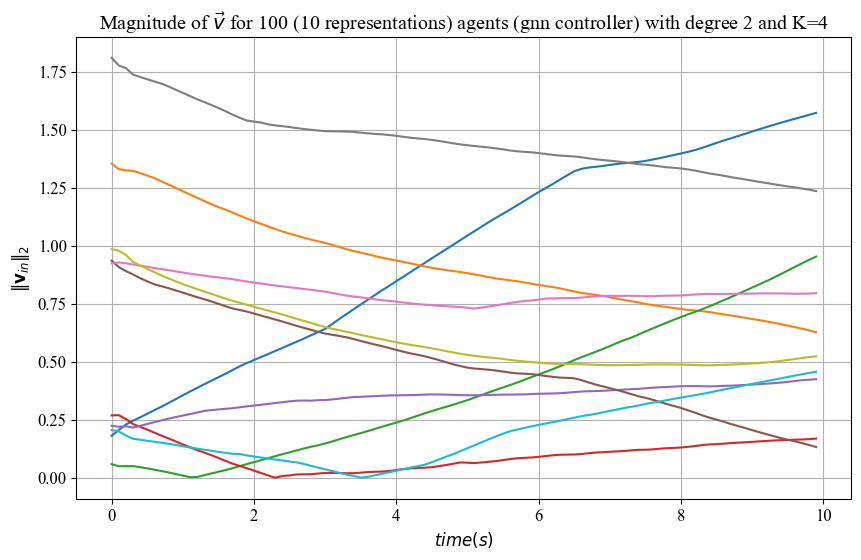

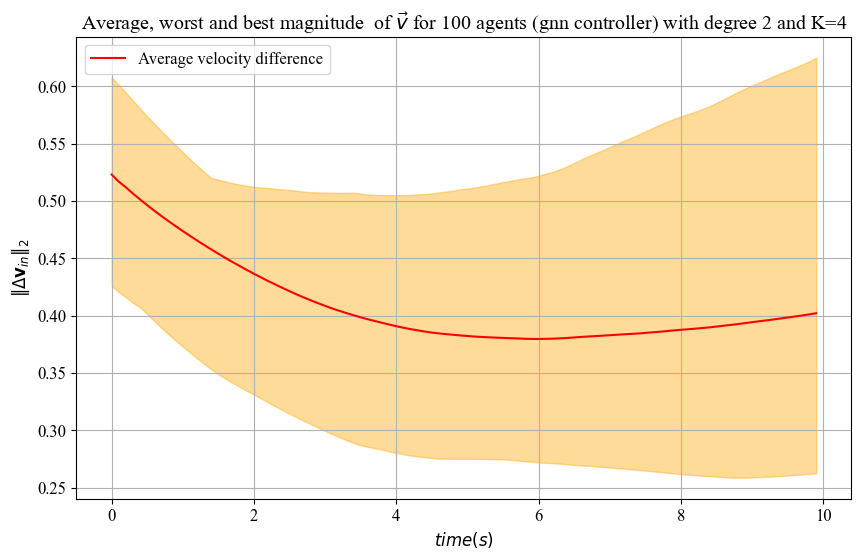

In [ ]:

thisArchit = callArchit(**hParamsDict)
thisArchit.to(thisDevice)
thisOptim = optim.Adam(thisArchit.parameters(), lr=learningRate, betas=(beta1, beta2))
thisLossFunction = nn.MSELoss()
GraphNNs = Model(thisArchit, thisLossFunction, thisOptim, Trainer, thisDevice, thisName, saveDir)

# Train
GraphNNs.train(simulator, ref_vel, est_vel, est_vels, biased_vels, accels, networkss, nEpochs, batchSize, positions, mobility=True)

# %%Test
ref_vel_test = ref_vel[200:220]
est_vel_test = est_vel[200:220]
pos_test = positions[200:220]
_, _, est_vels_valid, biased_vels_valid, accels_valid = simulator.computeTrajectory_pos(GraphNNs.archit, pos_test,
                                                                                        ref_vel_test, est_vel_test, 100)
cost = simulator.cost(est_vels_valid, biased_vels_valid, accels_valid)
print(cost)
print(np.shape(est_vels))

#%% Plotting
for i in range(0, 20, 2):
  plt.plot(np.arange(0, T, 0.1), np.sqrt(est_vels_valid[0, :, 0, i] ** 2 + est_vels_valid[0, :, 0, i] ** 2))

plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|{\bf v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10, 6)
plt.title(r'Magnitude of $\vec{v}$ for ' + str(N)+ ' (10 representations)' + ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
plt.grid()
# plt.savefig(fig_fold+'4_1.png', dpi=300)
plt.figure()

results_gnn = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels_valid[sim, t, 0, :] ** 2 + est_vels_valid[sim, t, 1, :] ** 2)

    results_gnn[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val_dec, max_val_dec = [], []
for t in range(100):
  min_val_dec.append(min(results_gnn[:, t]))
  max_val_dec.append(max(results_gnn[:, t]))

plt.plot(np.arange(0, T, 0.1),results_gnn.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val_dec, max_val_dec, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta  {\bf v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
# plt.savefig(fig_fold+'gnn_4-1.png', dpi=300)

It is important to now stop and think how to derive the decentralized controller in this setting. It is not trivial to allocate different weights accounting for different distances, and velocities, let alone accounting for delayed information in the graph. This makes GNNs even more valuable.

In [29]:
# Mobility rollout with the trained GNN
ref_vel_mob, est_vel_mob, est_vels_mob, biased_ref_vels_mob, accels_mob = \
    simulator.computeTrajectory_pos(
        GraphNNs.archit,   # trained GNN controller
        pos_test,          # positions[200:220] or whatever batch you chose
        ref_vel_test,      # ref_vel[200:220]
        est_vel_test,      # est_vel[200:220]
        100                # step count = 100 (T=10s, Ts=0.1)
    )

print("est_vels_mob shape:", est_vels_mob.shape)
print("biased_ref_vels_mob shape:", biased_ref_vels_mob.shape)


# Average reference over agents
avg_refs_mob = biased_ref_vels_mob.mean(axis=3)   # (num_sims, T_steps, 2)

def compute_avg_cost_from_vels(vels, avg_refs, Ts, lam):
    """
    vels    : (num_sims, T_steps, dim, N)
    avg_refs: (num_sims, T_steps, dim)
    Ts      : sampling time (0.1)
    lam     : lambda in the cost (1.0)
    """
    num_sims, T_steps, dim, N = vels.shape
    costs = np.zeros((num_sims, T_steps - 1))

    for s in range(num_sims):
        for t in range(T_steps - 1):
            v_n    = vels[s, t]       # (dim, N)
            v_next = vels[s, t + 1]   # (dim, N)
            u_n    = (v_next - v_n) / Ts

            r_avg_n = avg_refs[s, t].reshape(dim, 1)

            # tracking error: 1/(2N) * sum_i ||v_i^n - r̄_n||^2
            err   = v_n - r_avg_n
            term1 = 0.5 / N * np.sum(np.linalg.norm(err, axis=0)**2)

            # control energy: λ/(2N) * sum_i ||Ts u_i^n||^2
            term2 = lam * 0.5 / N * np.sum((Ts * np.linalg.norm(u_n, axis=0))**2)

            costs[s, t] = term1 + term2

    avg_cost       = costs.mean()        # scalar: over sims and time
    mean_cost_time = costs.mean(axis=0)  # per time step, averaged over sims

    return avg_cost, mean_cost_time


Ts  = 0.1
lam = 1.0

avg_cost_mob, mean_cost_time_mob = compute_avg_cost_from_vels(
    est_vels_mob,      # or est_vels_valid if you keep old names
    avg_refs_mob,
    Ts,
    lam
)

print("Average cost over all simulations (GNN with mobility):", avg_cost_mob)
print("Number of simulations:", est_vels_mob.shape[0])


est_vels_mob shape: (20, 100, 2, 100)
biased_ref_vels_mob shape: (20, 100, 2, 100)
Average cost over all simulations (GNN with mobility): 0.7027178062610628
Number of simulations: 20


In [ ]:
# Assumes GraphNNs is the model trained in Section 3 (static graphs).
# If needed, reload it: GraphNNs.load(label='Best')

T = 10
step = int(T / 0.1)

# Use mobility initial conditions (reuse the mobility dataset you already built)
# If you already ran simulate_pos(...), positions/ref_vel/est_vel are in memory:
ref_vel_test = ref_vel[200:220]
est_vel_test = est_vel[200:220]
pos_test = positions[200:220]

# Roll out the static-trained controller under mobility
ref_vel_out, est_vel_out, est_vels_mob, biased_ref_vels_mob, accels_mob = simulator.computeTrajectory_pos(
    GraphNNs.archit, pos_test, ref_vel_test, est_vel_test, step
)

# Compute cost
cost_mob = simulator.cost(est_vels_mob, biased_ref_vels_mob, accels_mob)
print(f"Mobility rollout cost (static-trained GNN): {cost_mob:.4f}")

# Plot agent speeds over time (similar to your current Section 4 first plot)
plt.figure(figsize=(10, 6))
for i in range(0, 100, 5):
    plt.plot(np.arange(0, T, 0.1), np.sqrt(est_vels_mob[0, :, 0, i]**2 + est_vels_mob[0, :, 1, i]**2))
plt.xlabel('time (s)')
plt.ylabel(r'$\|{\bf v}_{in}\|_2$')
plt.grid()
plt.show()

# Plot average velocity dispersion over time (similar to your second plot)
results_gnn_mob = np.zeros((10, step))
for sim in range(10):
    for t in range(step):
        curr = np.sqrt(est_vels_mob[sim, t, 0, :]**2 + est_vels_mob[sim, t, 1, :]**2)
        results_gnn_mob[sim, t] = np.sqrt((curr - curr.mean())**2).mean()

min_val_dec, max_val_dec = [], []


## 5 Collision and Spread Avoidance

The second aspect of the problem that changes when we incorporate mobility is that agents can get too close to each other, which would result in a collision. Agents can also get too far apart, which would result in their inability to communicate. To prevent both outcomes we utilize a potential function to encourage neighboring agents to stay within a target distance of each other. Formally, let $\mathbf{p}_{in}$ be the position of agent $i$ at time $n$ and $\mathbf{p}_{jn}$ be the position of agent $j$. Agent $j$ is a neighbor of agent $i$. We then define the potential

$$U(\mathbf{p}_{in}, \mathbf{p}_{jn}) = \frac{d_0^2}{|\mathbf{p}_{in} - \mathbf{p}_{jn}|^2} + \log\left[\frac{|\mathbf{p}_{in} - \mathbf{p}_{jn}|^2}{d_0^2}\right]$$

This potential function has a minimum when the distance between agents $i$ and $j$ is $|\mathbf{p}_{in} - \mathbf{p}_{jn}|^2 = d_0$.

The potentials $U(\mathbf{p}_{in}, \mathbf{p}_{jn})$ in the above equation are added to the cost function to define the loss function

$$\ell(\mathbf{P}_n, \mathbf{V}_n, \mathbf{R}_n, \mathbf{U}_n) = c(\mathbf{V}_n, \mathbf{R}_n, \mathbf{U}_n) + \frac{\mu}{2N} \sum_{i=1}^N \frac{1}{\#\left(\mathcal{N}_{in}\right)} \sum_{j\in\mathcal{N}_{in}} U(\mathbf{p}_{in}, \mathbf{p}_{jn}) .$$

The optimal centralized controller is the one that greedily minimizes the cost in the above equation at each time step. Our goal in this section is to learn a GNN controller that mimics this optimal centralized controller.

Before we set out to design this GNN, we define the following feature at node $i$,

$$\mathbf{q}_{in} = \frac{1}{\#\left(\mathcal{N}_{in}\right)} \sum_{j\in\mathcal{N}_{in}} (\mathbf{p}_{in} - \mathbf{p}_{jn}) .$$

This is the center of mass of the neighbors of $i$ measured relative to the position of node $i$. In this definition, it is not very important that $\mathbf{q}_{in}$ be a center of mass. But it is *very* important that the measure be *relative* so as to preserve permutation equivariance. This is because GNNs are equivariant to node relabeling, and thus if we consider distances measured relative to the node, we can leverage the properties of the GNN. This translates into signals that will require the same output independent of which node is being considered, only the distance to its neighbors carries valuable information for avoiding collisions.

Now we are going to learn a distributed policy that mimics the optimal centralized controller that minimizes the cost in the above equation with a GNN. The input features to the GNN are $\mathbf{V}_n$, $\mathbf{R}_n$, and $\mathbf{Q}_n$.

Here we can see that the GNN works well on a decentralized setting. It is important to note that although controllers can be obtained for the easy setting of consensus, as more information and requirements are added, the controllers become computationally costly and difficult to obtain. Besides, as we have seen in section 3, they do not always work in practice.

### 5.1-5.2 Collision Avoidance
We create the python class OptimalControllerCollision for the optimal centralized controller with collision avoidance as:

In [12]:
class OptimalControllerCollision(ConsensusController):
    def __init__(self, sample_time=0.1, energy_weight=1):
        self.sample_time = sample_time
        self.energy_weight = energy_weight

    def __call__(self, gama, d0, pos, est_vel, biased_vel, step):
        ijDiffPos, ijDistSq = computeDifferences(pos[:, step, :, :])
        gammaMask = (ijDistSq < (gama ** 2)).astype(ijDiffPos.dtype)
        ijDiffPos = ijDiffPos * np.expand_dims(gammaMask, 1)
        ijDistSqInv = ijDistSq.copy()
        ijDistSqInv[ijDistSq < 1e-9] = 1.
        ijDistSqInv = 1. / ijDistSqInv
        ijDistSqInv[ijDistSq < 1e-9] = 0.
        ijDistSqInv = np.expand_dims(ijDistSqInv, 1)
        mean_biased_vel = np.mean(biased_vel[:, step, :, :], axis=2)
        mean_biased_vel = np.expand_dims(mean_biased_vel, 2)
        accel = -(est_vel[:, step, :, :] - mean_biased_vel) / (
                    self.sample_time * (1 + self.energy_weight)) + 1 / self.sample_time / 2 * 2 * np.sum(
            ijDiffPos * (d0 * d0 * (ijDistSqInv ** 2) + d0 * d0 * ijDistSqInv), axis=3)

        return accel

We first generate dataset for imitation, now with the simulation function that considers collision (**simulate_pos_collision**):

In [14]:
# %% Parameters
D = 2
K = 4
nSamples = 240
N = 100
T=10
step = int(T/0.1)

fig_fold = 'figures_part4/'
network = np.zeros((nSamples, N, N))
com_network = np.zeros((nSamples, step, N, N))

In [15]:
simulator = ConsensusSimulator(N, nSamples)
optimal_controller_collision = OptimalControllerCollision()
networkss, positions, ref_vel, est_vel, est_vels, biased_vels, accels = simulator.simulate_pos_collision(100, 200, D,
                                                                                                         100,
                                                                                                         optimal_controller_collision)


	(E:  1, B:   1) 429.4528 - 22.3077s [VALIDATION] 
	(E:  2, B:   1) 320.2795 - 36.9766s [VALIDATION] 
	=> New best achieved: 320.2795
	(E:  3, B:   1) 265.4798 - 27.9830s [VALIDATION] 
	=> New best achieved: 265.4798
	(E:  4, B:   1) 221.7086 - 36.9793s [VALIDATION] 
	=> New best achieved: 221.7086
	(E:  5, B:   1) 172.5391 - 37.7244s [VALIDATION] 
	=> New best achieved: 172.5391
	(E:  6, B:   1) 150.6661 - 36.2587s [VALIDATION] 
	=> New best achieved: 150.6661
	(E:  7, B:   1) 136.1582 - 38.0919s [VALIDATION] 
	=> New best achieved: 136.1582
	(E:  8, B:   1) 141.5431 - 34.5756s [VALIDATION] 
	(E:  9, B:   1) 130.0317 - 17.9435s [VALIDATION] 
	=> New best achieved: 130.0317
	(E: 10, B:   1) 119.5260 - 18.1746s [VALIDATION] 
	=> New best achieved: 119.5260
	(E: 11, B:   1) 117.1387 - 18.5028s [VALIDATION] 
	=> New best achieved: 117.1387
	(E: 12, B:   1) 110.8297 - 20.2839s [VALIDATION] 
	=> New best achieved: 110.8297
	(E: 13, B:   1) 117.4910 - 25.2932s [VALIDATION] 
	(E: 14, B:   1) 

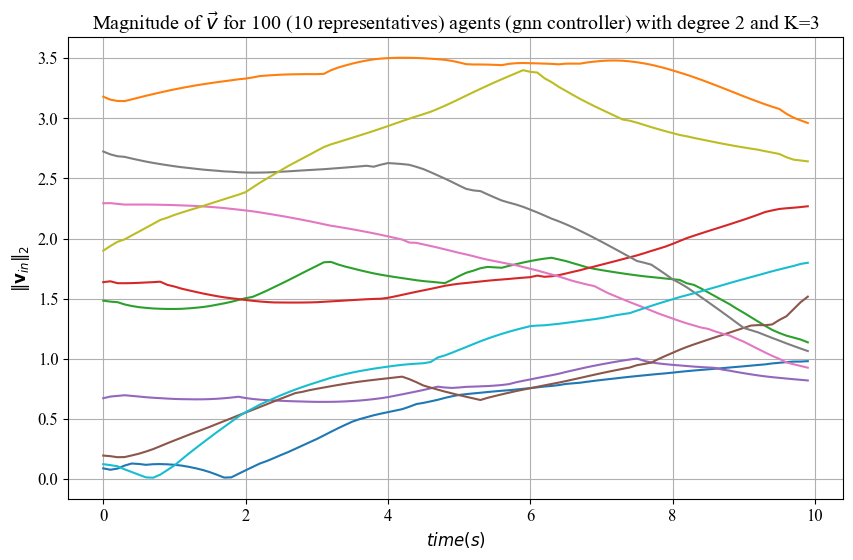

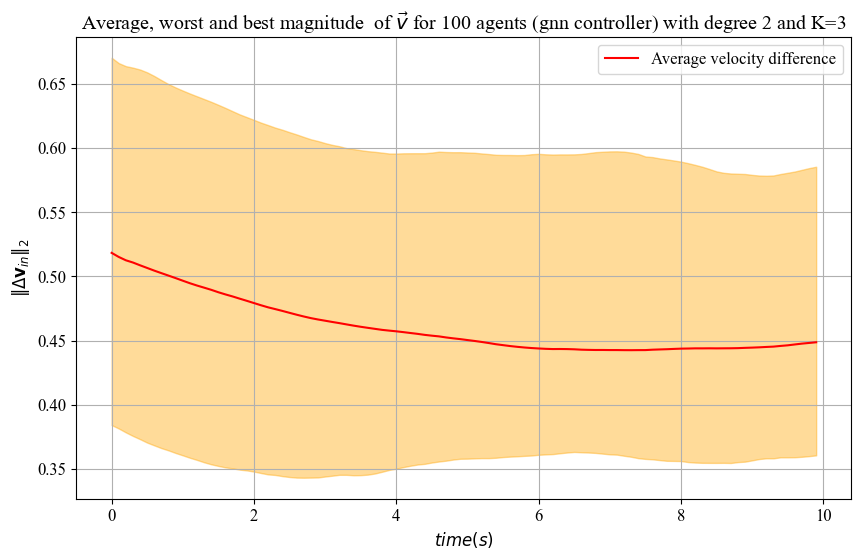

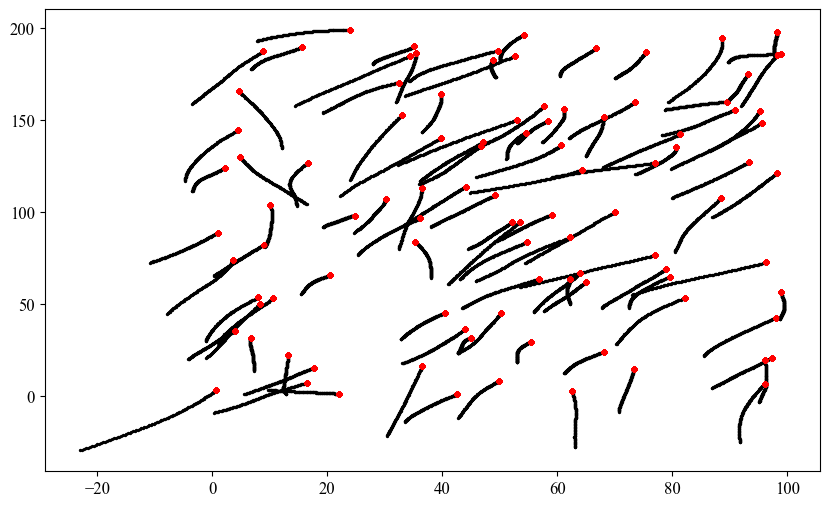

In [21]:
nEpochs = 50  # Number of epochs
batchSize = 20  # Batch size
learningRate = 0.00025
beta1 = 0.9
beta2 = 0.999

hParamsLocalGNN = {}  # Hyperparameters (hParams) for the Local GNN
hParamsLocalGNN['name'] = 'LocalGNN'
hParamsLocalGNN['archit'] = LocalGNN_DB
hParamsLocalGNN['device'] = 'cuda:0' \
    if (True and torch.cuda.is_available()) \
    else 'cpu'
hParamsLocalGNN['dimNodeSignals'] = [6, 64]  # Features per layer
hParamsLocalGNN['nFilterTaps'] = [4]  # Number of filter taps
hParamsLocalGNN['bias'] = True
hParamsLocalGNN['nonlinearity'] = nn.Tanh
hParamsLocalGNN['dimReadout'] = [2]
hParamsLocalGNN['dimEdgeFeatures'] = 1

if torch.cuda.is_available():
    torch.cuda.empty_cache()
hParamsDict = deepcopy(hParamsLocalGNN)
thisName = hParamsDict.pop('name')
callArchit = hParamsDict.pop('archit')
thisDevice = hParamsDict.pop('device')
##############
# PARAMETERS #
##############

thisArchit = callArchit(**hParamsDict)
thisArchit.to(thisDevice)
thisOptim = optim.Adam(thisArchit.parameters(), lr=learningRate, betas=(beta1, beta2))
thisLossFunction = nn.MSELoss()
GraphNNs = Model(thisArchit, thisLossFunction, thisOptim, Trainer, thisDevice, thisName, saveDir)

# Train
GraphNNs.train(simulator, ref_vel, est_vel, est_vels, biased_vels, accels, networkss, nEpochs, batchSize, positions, mobility=True, collision=True)

# Test
ref_vel_test = ref_vel[200:220]
est_vel_test = est_vel[200:220]
pos_test = positions[200:220]
_, _, est_vels_valid, biased_vels_valid, accels_valid, pos_gnn = simulator.computeTrajectory_pos_collision(GraphNNs.archit,
                                                                                                  pos_test,
                                                                                                  ref_vel_test,
                                                                                                  est_vel_test, 100)
cost = simulator.cost(est_vels_valid, biased_vels_valid, accels_valid)
print(cost)

# %% Plotting

print(np.shape(est_vels_valid))
for i in range(0, 20, 2):
  plt.plot(np.arange(0, T, 0.1), np.sqrt(est_vels_valid[0, :, 0, i] ** 2 + est_vels_valid[0, :, 0, i] ** 2))

plt.xlabel(r'$time (s)$')
plt.ylabel(r'$\|{\bf v}_{in}\|_2$')
plt.rcParams["figure.figsize"] = (10, 6)
plt.title(r'Magnitude of $\vec{v}$ for ' + str(N)+ ' (10 representatives)' + ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
plt.grid()
# plt.savefig(fig_fold+'4.png', dpi=300)
plt.figure()

results_gnn = np.zeros((10, 100))

for sim in range(10):
  for t in range(100):
    curr_step = np.sqrt(est_vels_valid[sim, t, 0, :] ** 2 + est_vels_valid[sim, t, 1, :] ** 2)

    results_gnn[sim, t] = np.sqrt((curr_step - curr_step.mean()) ** 2).mean()

min_val_dec, max_val_dec = [], []
for t in range(100):
  min_val_dec.append(min(results_gnn[:, t]))
  max_val_dec.append(max(results_gnn[:, t]))

plt.plot(np.arange(0, T, 0.1),results_gnn.mean(axis=0), color='red',
                 label='Average velocity difference')

plt.fill_between(np.arange(0, T, 0.1), min_val_dec, max_val_dec, alpha=0.4, color='orange')

plt.legend()
plt.grid()
plt.xlabel('$time (s)$')
plt.ylabel(r'$\|\Delta {\bf v}_{in}\|_2$')
plt.title(r'Average, worst and best magnitude  of $\vec{v}$ for ' + str(N)+ ' agents (gnn controller) with degree ' + str (D)+' and K='+str(K))
# plt.savefig(fig_fold+'gnn_5.png', dpi=300)

plt.show()

sample = 0
for t in range(0, pos_gnn.shape[1]):
    plt.scatter(pos_gnn[sample, t, 0, :], 
                pos_gnn[sample, t, 1, :], 
                marker='.', 
                color='black',
                s=8)

    plt.scatter(pos_gnn[sample, 0, 0, :], 
                pos_gnn[sample, 0, 1, :], 
                marker='.', 
                color='red')
# plt.savefig(fig_fold+'positions.png', dpi=300)
plt.show()



In [23]:
# Assumes Section 5 variables already in scope:
# simulator, GraphNNs (trained with mobility+collision), positions, ref_vel, est_vel
# and T = 10 so step = 100 (0.1 s sampling)

num_sims = 100
step = int(T / 0.1)

# Use the first 100 mobility/collision initial conditions from your dataset
pos_batch = positions[:num_sims]
ref_batch = ref_vel[:num_sims]
est_batch = est_vel[:num_sims]

# Roll out the trained GNN under mobility + collision
ref_out, est_out, est_vels_gnn, biased_ref_vels_gnn, accels_gnn, _ = simulator.computeTrajectory_pos_collision(
    GraphNNs.archit, pos_batch, ref_batch, est_batch, step
)

# Compute cost; simulator.cost already averages over the batch
avg_cost_100 = simulator.cost(est_vels_gnn, biased_ref_vels_gnn, accels_gnn)
print(f"Average cost over {num_sims} mobility+collision simulations: {avg_cost_100:.4f}")



Average cost over 100 mobility+collision simulations: 79.3462
